In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "src/output"

/Users/athul/Documents/CS C182/182-Final-Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Time Domain Analysis
Here, we can run a selected **time domain** trained model and visualize its predictions. To change the model being evaluated, edit the filepath in `run_path_time`.

In [3]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [4]:
run_path_time = "output/bigbatch_star"

model_time, conf_time = get_model_from_run(run_path_time)

# Move model to appropriate device
if torch.cuda.is_available():
    model = model_time.cuda()
elif torch.backends.mps.is_available():
    model = model_time.to("mps")
model.eval()

n_dims = conf_time.model.n_dims
batch_size = 1000

# Override device for samplers
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

data_kwargs = dict(conf_time.training.data_kwargs)
task_kwargs = dict(conf_time.training.task_kwargs)
data_kwargs['device'] = device
task_kwargs['device'] = device

data_sampler = get_data_sampler(conf_time.training.data, n_dims, **data_kwargs)
task_sampler = get_task_sampler(
    conf_time.training.task,
    n_dims,
    batch_size,
    **task_kwargs
)

In [5]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_time.training.curriculum.points.end)
ys = task.evaluate(xs)

In [6]:
with torch.no_grad():
    xs_device = xs.to(model_time.device if hasattr(model_time, 'device') else device)
    ys_device = ys.to(model_time.device if hasattr(model_time, 'device') else device)
    pred = model(xs_device, ys_device).cpu()

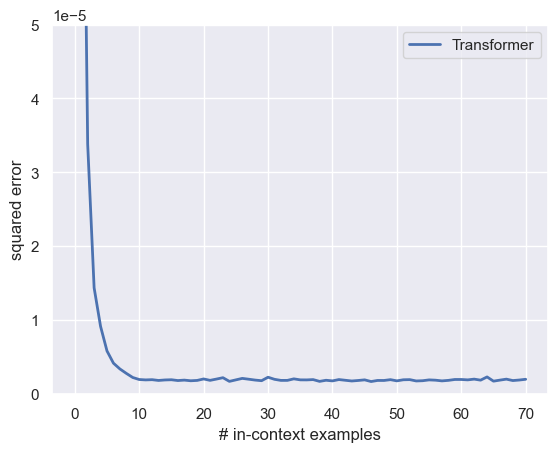

In [7]:
metric = task.get_metric()
# Compute per-point MSE
preds_np = pred.cpu().numpy()
ys_np = ys.cpu().numpy()
loss = ((preds_np - ys_np) ** 2).mean(axis=(0, 2))  # mean over batch and features, keep n_points

plt.plot(loss, lw=2, label="Transformer")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(0, .00005)
plt.legend()
plt.show()

## Time Domain Example Predictions

In [8]:
xs2 = xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    xs2_device = xs2.to(model.device if hasattr(model, 'device') else device)
    ys2_device = ys2.to(model.device if hasattr(model, 'device') else device)
    pred2 = model(xs2_device, ys2_device).cpu() #gather time predictions

In [9]:
def plot_signal_examples(xs, ys, pred, conf, example_idx=0, n_points_to_show=10):
    """
    Stem-plot visualization of:
        - Input signal x
        - True output y
        - Predicted output ŷ

    Args:
        xs:   tensor (B, T, p or 2p)
        ys:   tensor (B, T, p or 2p)
        pred: tensor (B, T, p or 2p)
        conf: full training config (for domain strings)
        example_idx: which batch element to plot
        n_points_to_show: number of (x,y) examples to visualize
    """

    fig, axes = plt.subplots(n_points_to_show, 3, figsize=(15, 3*n_points_to_show))
    if n_points_to_show == 1:
        axes = axes.reshape(1, -1)

    domain_x = ('Time' if conf["training"]["data_kwargs"]["domain"] == "time"
                else "Time")
    domain_y = ('Time' if conf["training"]["task_kwargs"]["domain"] == "time"
                else "Time")

    for point_idx in range(n_points_to_show):

        x_signal = xs[example_idx, point_idx].cpu().numpy()
        y_true   = ys[example_idx, point_idx].cpu().numpy()
        y_pred   = pred[example_idx, point_idx].cpu().numpy()

        # --- Input signal ---
        axes[point_idx, 0].stem(
            x_signal, linefmt='b-', markerfmt='bo', basefmt='k-'
        )
        axes[point_idx, 0].set_title(f'Input Signal (point {point_idx+1})')
        axes[point_idx, 0].set_xlabel(domain_x)
        axes[point_idx, 0].grid(True, alpha=0.3)

        # --- True output ---
        axes[point_idx, 1].stem(
            y_true, linefmt='g-', markerfmt='go', basefmt='k-'
        )
        axes[point_idx, 1].set_title(f'True Output (point {point_idx+1})')
        axes[point_idx, 1].set_xlabel(domain_y)
        axes[point_idx, 1].grid(True, alpha=0.3)

        # --- Prediction vs true ---
        axes[point_idx, 2].stem(
            y_true, linefmt='g-', markerfmt='go', basefmt='k-', label='True'
        )
        axes[point_idx, 2].stem(
            y_pred, linefmt='r--', markerfmt='ro', basefmt='k-', label='Pred'
        )
        axes[point_idx, 2].set_title(f'Prediction vs True (point {point_idx+1})')
        axes[point_idx, 2].set_xlabel(domain_y)
        axes[point_idx, 2].legend()
        axes[point_idx, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Final-point error
    final_error = ((y_pred - y_true) ** 2).mean()
    print(f"MSE for final point: {final_error:.6f}")

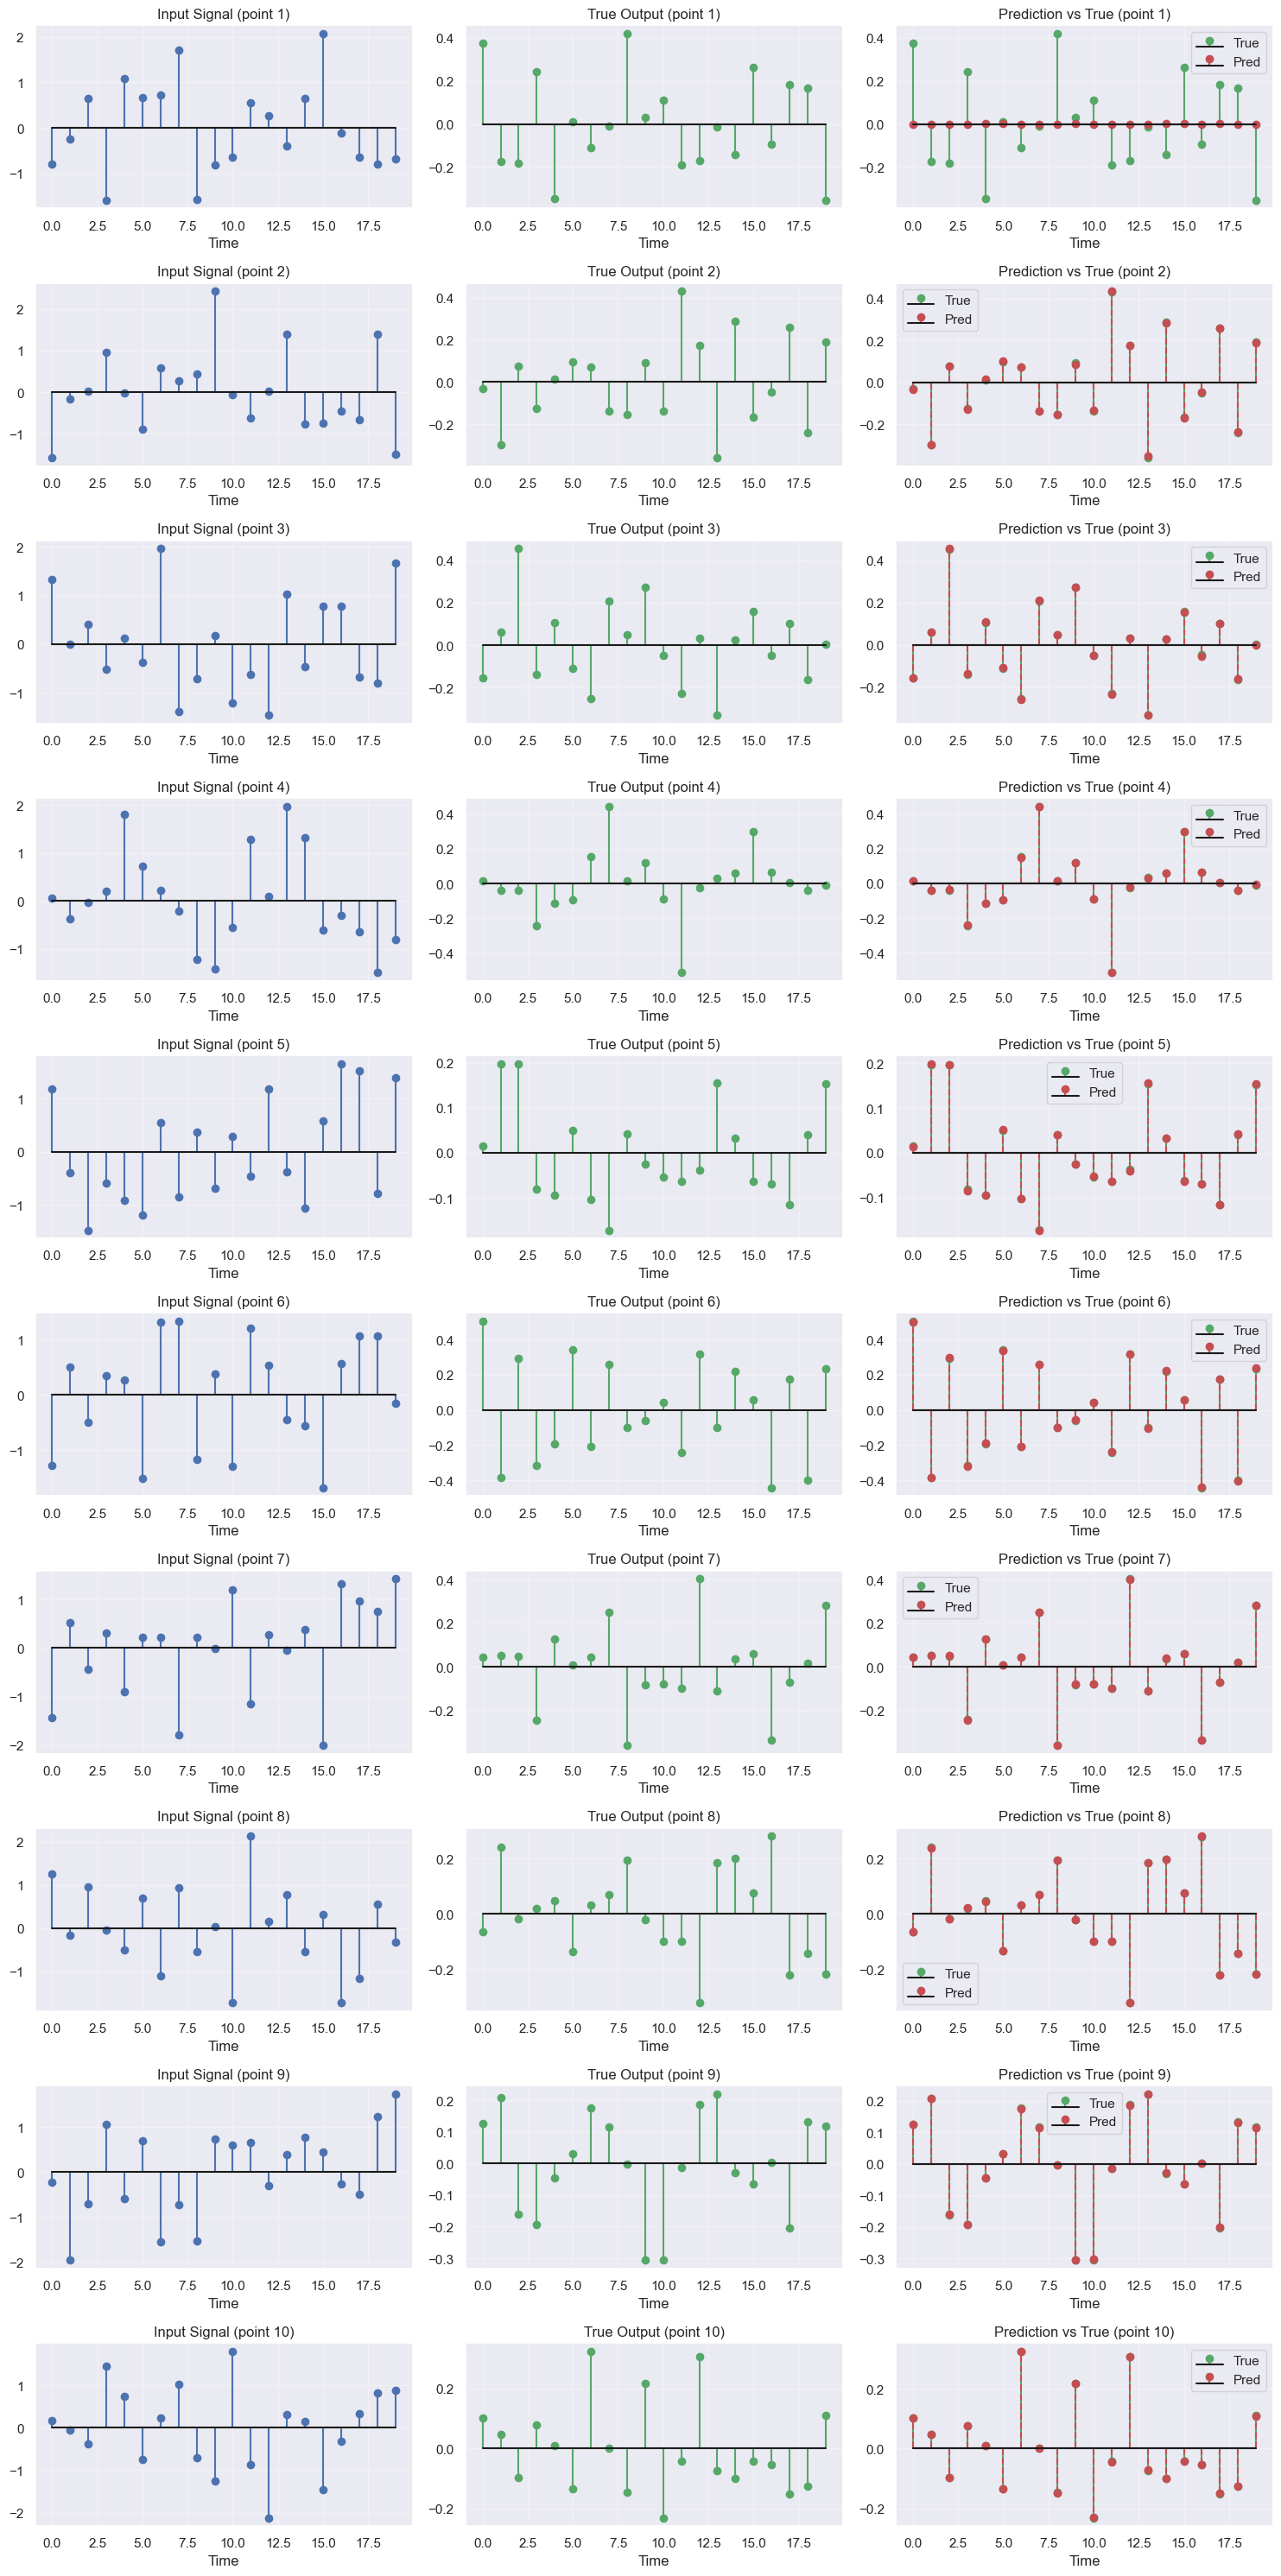

MSE for final point: 0.000002


In [10]:
plot_signal_examples(xs, ys, pred, conf_time, example_idx=0, n_points_to_show=10)


# Frequency Analysis
Here, we can run a selected **frequency domain** trained model and visualize its predictions. To change the model being evaluated, edit the filepath in `run_path_freq`.

In [11]:
run_path_freq = "output/freq_p20_fir5_loss_space_time_b256_dec8_1437"

# Load configs to verify
_, conf_freq = get_model_from_run(run_path_freq, only_conf=True)

print("Freq domain model:", conf_freq.training.data_kwargs.domain, "n_dims:", conf_freq.model.n_dims)

Freq domain model: freq n_dims: 22


In [12]:
# Choose which model to evaluate

# Compute metrics (this will save to metrics.json in the run directory)
recompute_metrics = True
if recompute_metrics:
    metrics = get_run_metrics(run_path_freq)

100%|██████████| 1/1 [00:00<00:00, 9822.73it/s]


In [13]:
model_freq, conf_freq = get_model_from_run(run_path_freq)

# Move model to appropriate device
if torch.cuda.is_available():
    model_freq = model_freq.cuda()
elif torch.backends.mps.is_available():
    model_freq = model_freq.to("mps")
model_freq.eval()

n_dims = conf_freq.model.n_dims
batch_size = 1000

# Override device for samplers
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

data_kwargs = dict(conf_freq.training.data_kwargs)
task_kwargs = dict(conf_freq.training.task_kwargs)
data_kwargs['device'] = device
task_kwargs['device'] = device

data_sampler = get_data_sampler(conf_freq.training.data, n_dims, **data_kwargs)
task_sampler = get_task_sampler(
    conf_freq.training.task,
    n_dims,
    batch_size,
    **task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_freq.training.curriculum.points.end)
ys = task.evaluate(xs)

In [14]:
def _interleaved_to_complex(vec_2p: torch.Tensor) -> torch.Tensor:
    re = vec_2p[..., 0::2]
    im = vec_2p[..., 1::2]
    return torch.complex(re, im)


def interleaved_freq_to_time(xs_freq: torch.Tensor, p: int) -> torch.Tensor:
    """
    xs_freq: (B, T, 2p) real, interleaved [Re0, Im0, Re1, Im1, ...] along the last dim
    p: signal length in time domain
    fft_norm: must match the norm used in forward FFT ('ortho' in your case)

    Returns:
        xs_time: (B, T, p) real time-domain signals
    """
    # 1. Convert interleaved real/imag back to complex
    Z = _interleaved_to_complex(xs_freq)   # shape: (B, T, p), complex

    # 2. IFFT along the last dimension
    xs_time = torch.fft.irfft(Z,  dim=-1, norm = "ortho").real
    return xs_time


def time_to_interleaved_freq(x_time: torch.Tensor) -> torch.Tensor:
    """
    Convert time-domain signal to interleaved real/imag frequency representation.
    
    x_time: (B, T, p) real time-domain signals
    
    Returns:
        xs_freq: (B, T, 2*(p//2+1)) real, interleaved [Re0, Im0, Re1, Im1, ...]
    """
    # Apply rfft with ortho normalization (matches the sampler's encoding)
    X_freq = torch.fft.rfft(x_time, dim=-1, norm="ortho")  # (B, T, p//2+1) complex
    
    # Interleave real and imaginary parts
    re = X_freq.real
    im = X_freq.imag
    # Stack and reshape to interleave: [re0, im0, re1, im1, ...]
    interleaved = torch.stack([re, im], dim=-1).flatten(start_dim=-2)  # (B, T, 2*(p//2+1))
    return interleaved

In [15]:
with torch.no_grad():
    xs_device = xs.to(model_freq.device if hasattr(model_freq, 'device') else device)
    ys_device = ys.to(model_freq.device if hasattr(model_freq, 'device') else device)
    pred_freq = model_freq(xs_device, ys_device).cpu()

In [16]:
p = (xs.shape[-1] -1) * 2

xs_freq_to_time = interleaved_freq_to_time(xs, p)
ys_freq_to_time = interleaved_freq_to_time(ys, p)
pred_freq_to_time = interleaved_freq_to_time(pred_freq, p)

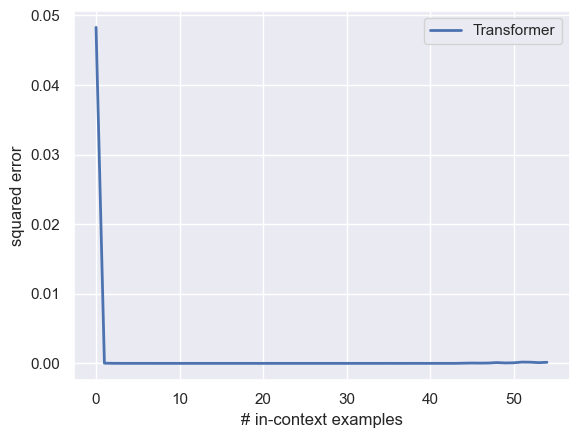

In [17]:
#Frequency Domain
metric = task.get_metric()
# Compute per-point MSE
preds_np = pred_freq_to_time.cpu().numpy()
ys_np = ys_freq_to_time.cpu().numpy()
loss = ((preds_np - ys_np) ** 2).mean(axis=(0, 2))  # mean over batch and features, keep n_points

plt.plot(loss, lw=2, label="Transformer")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

## Frequency Domain Example Predictions

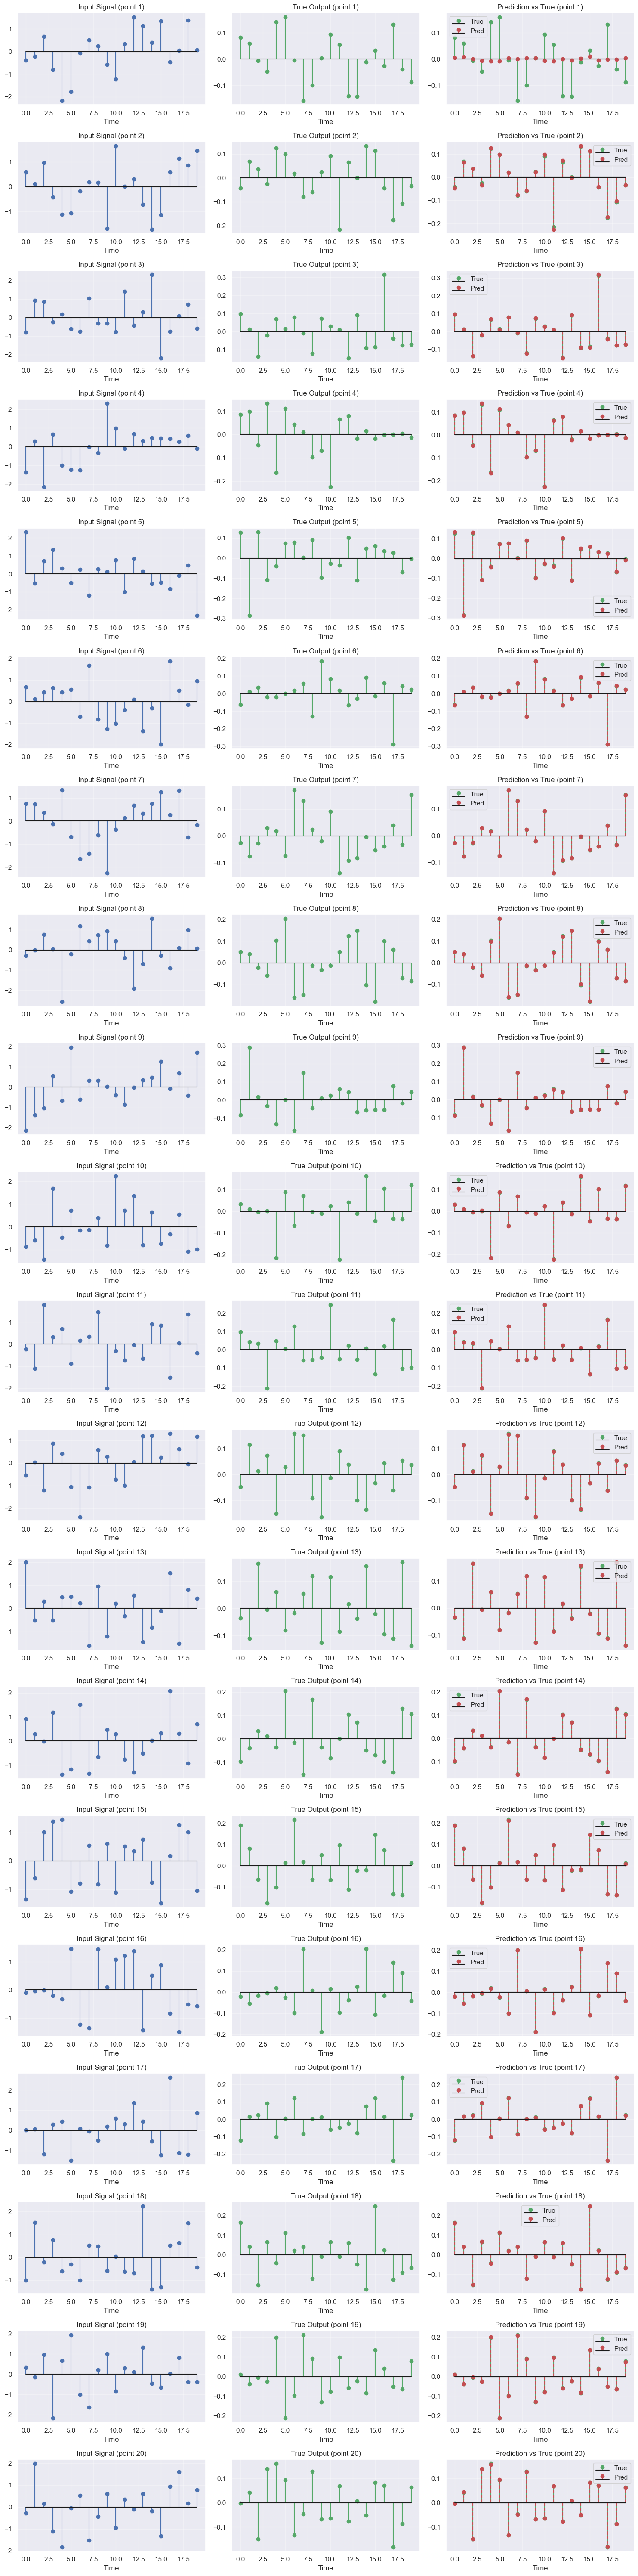

MSE for final point: 0.000002


In [18]:
plot_signal_examples(xs_freq_to_time, ys_freq_to_time, pred_freq_to_time, conf_time, example_idx=0, n_points_to_show=20) #Example Frequency domain predictions


## Squared error vs in-context examples for multiple models

In this section we compare four models, across both the frequency and time domains, by plotting their **time-domain squared error** as a function of the number of in-context examples. For each model we compute the per-point MSE across the batch and then plot the **batch mean** with a **standard deviation band**.



Generating shared test data for FIR5 group
  Reference model: output/time_p20_fir5_context_batch256_dec4_1229
  fir_len: 5
  num_freqs: 20
  xs_time shape: torch.Size([256, 55, 20])
  ys_time shape: torch.Size([256, 55, 20])
  xs_freq shape: torch.Size([256, 55, 22])
  ys_freq shape: torch.Size([256, 55, 22])

Generating shared test data for FIR20 group
  Reference model: output/bigbatch_star
  fir_len: 20
  num_freqs: 20
  xs_time shape: torch.Size([256, 55, 20])
  ys_time shape: torch.Size([256, 55, 20])
  xs_freq shape: torch.Size([256, 55, 22])
  ys_freq shape: torch.Size([256, 55, 22])

Evaluating Frequency Period 20, FIR 5 from output/freq_p20_fir5_loss_space_time_b256_dec8_1437 ...
  Using FIR5 freq domain data: torch.Size([256, 55, 22])


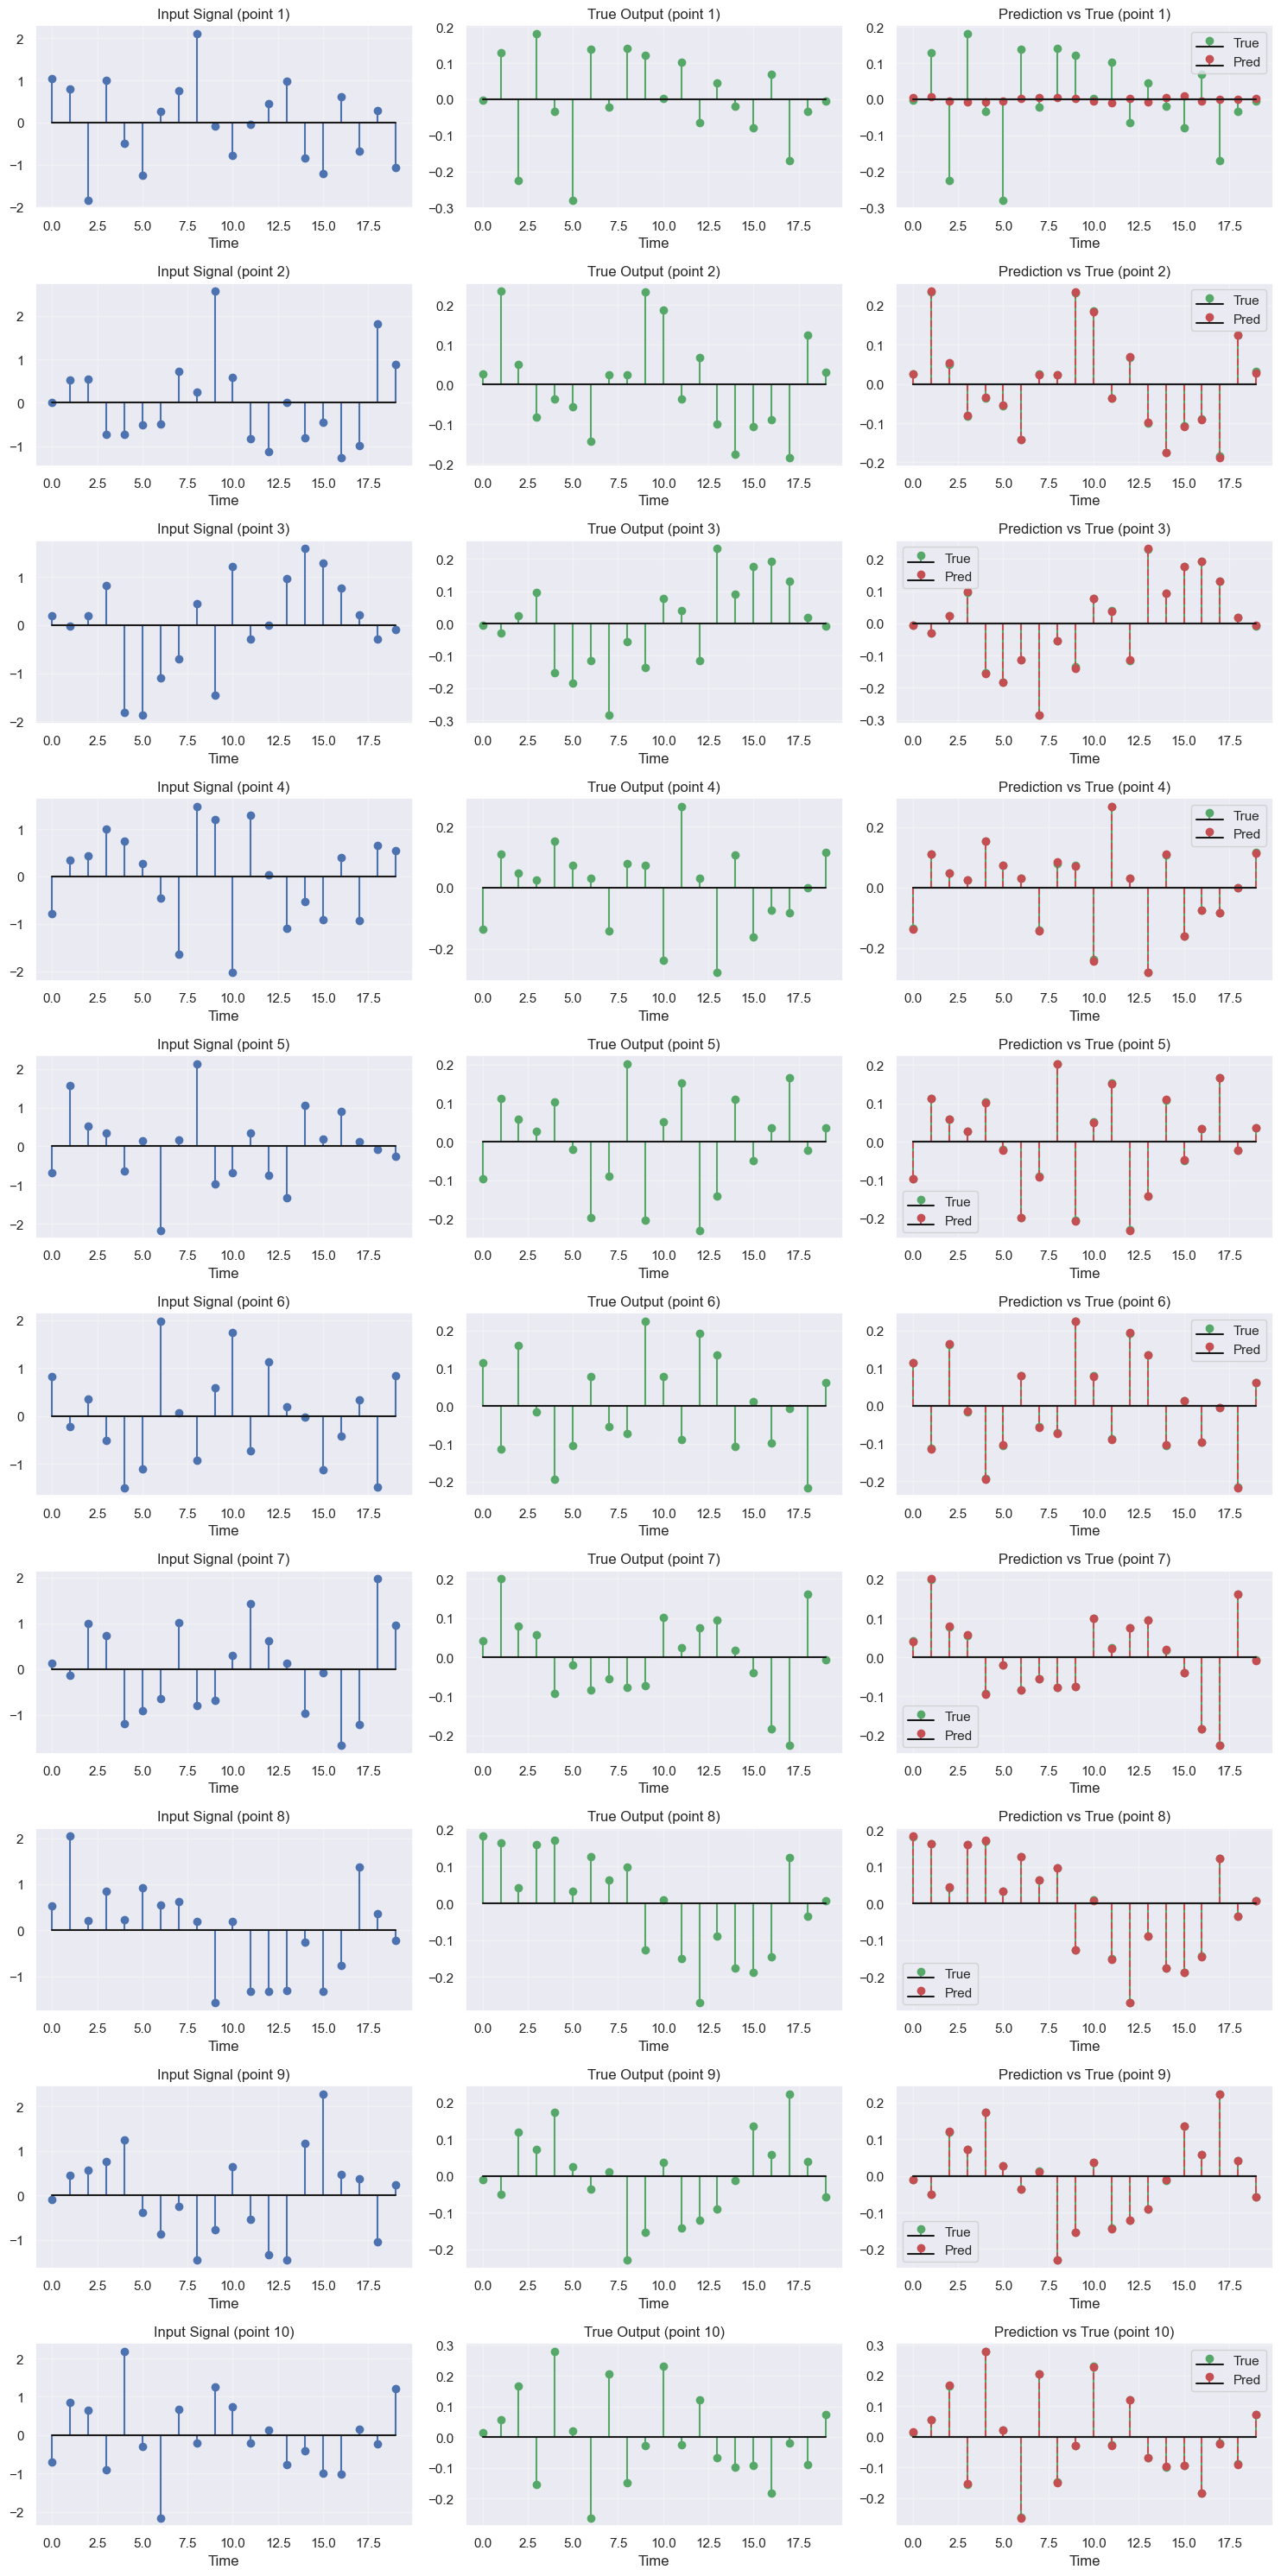

MSE for final point: 0.000001

Evaluating Frequency Period 20, FIR 20 from output/freq_p20_fir20_loss_space_time_b256_dec4_1443 ...
  Using FIR20 freq domain data: torch.Size([256, 55, 22])


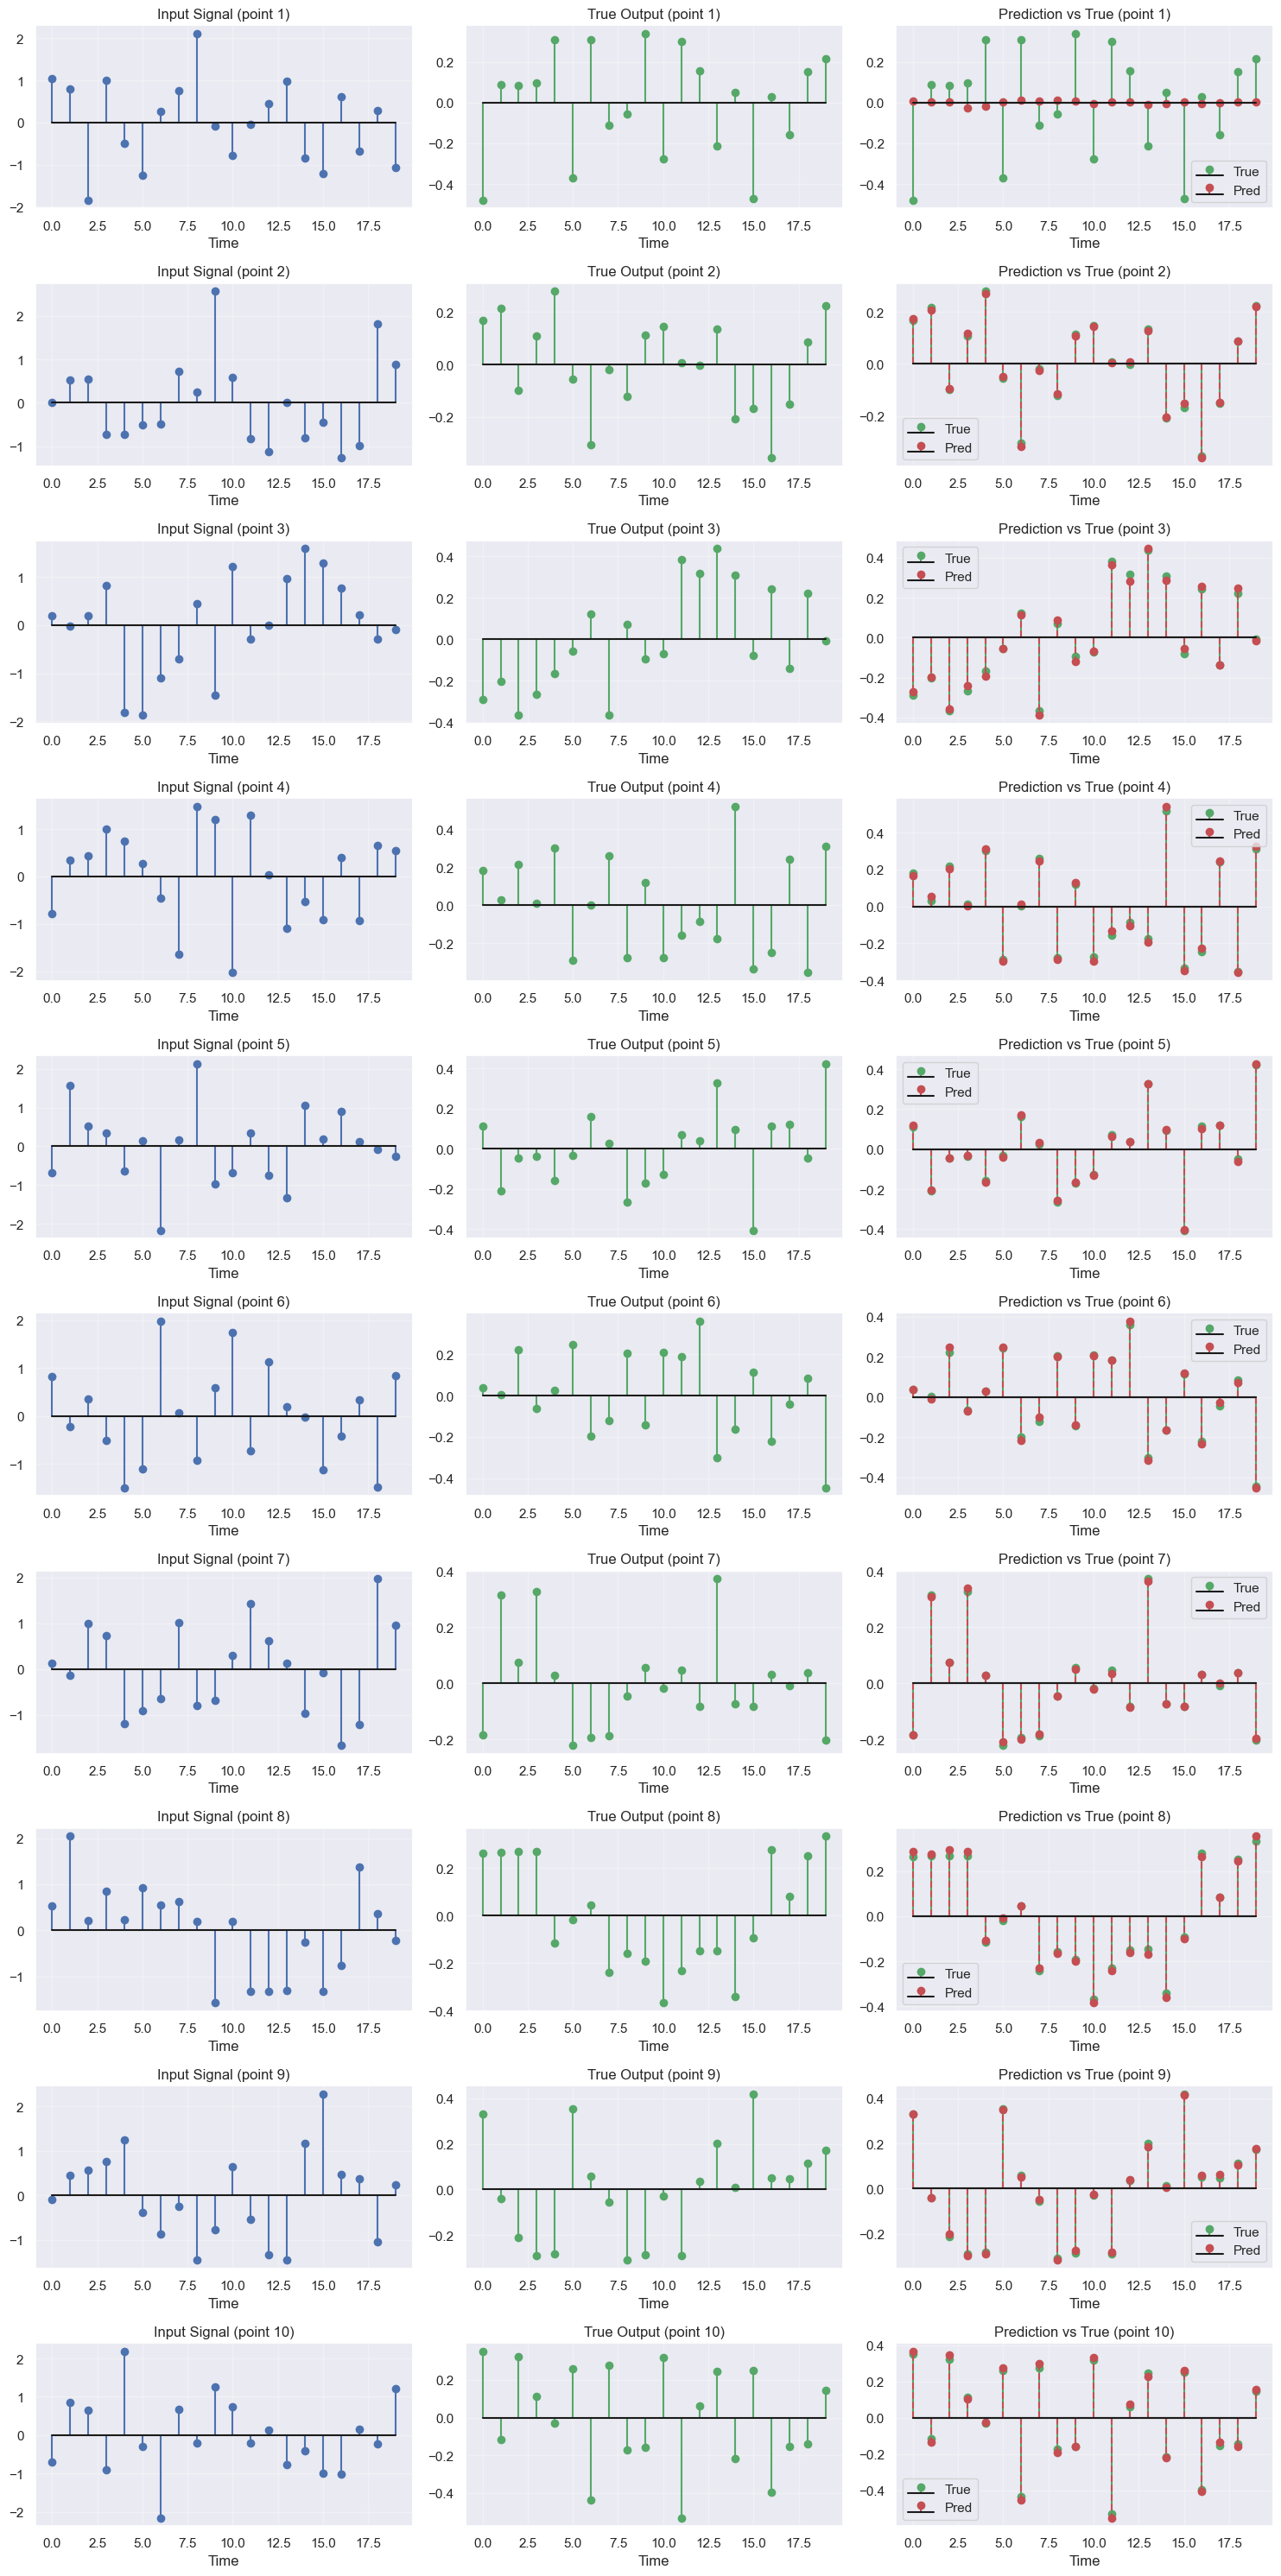

MSE for final point: 0.000243

Evaluating Time Period 20, FIR 5 from output/time_p20_fir5_context_batch256_dec4_1229 ...
  Using FIR5 time domain data: torch.Size([256, 55, 20])


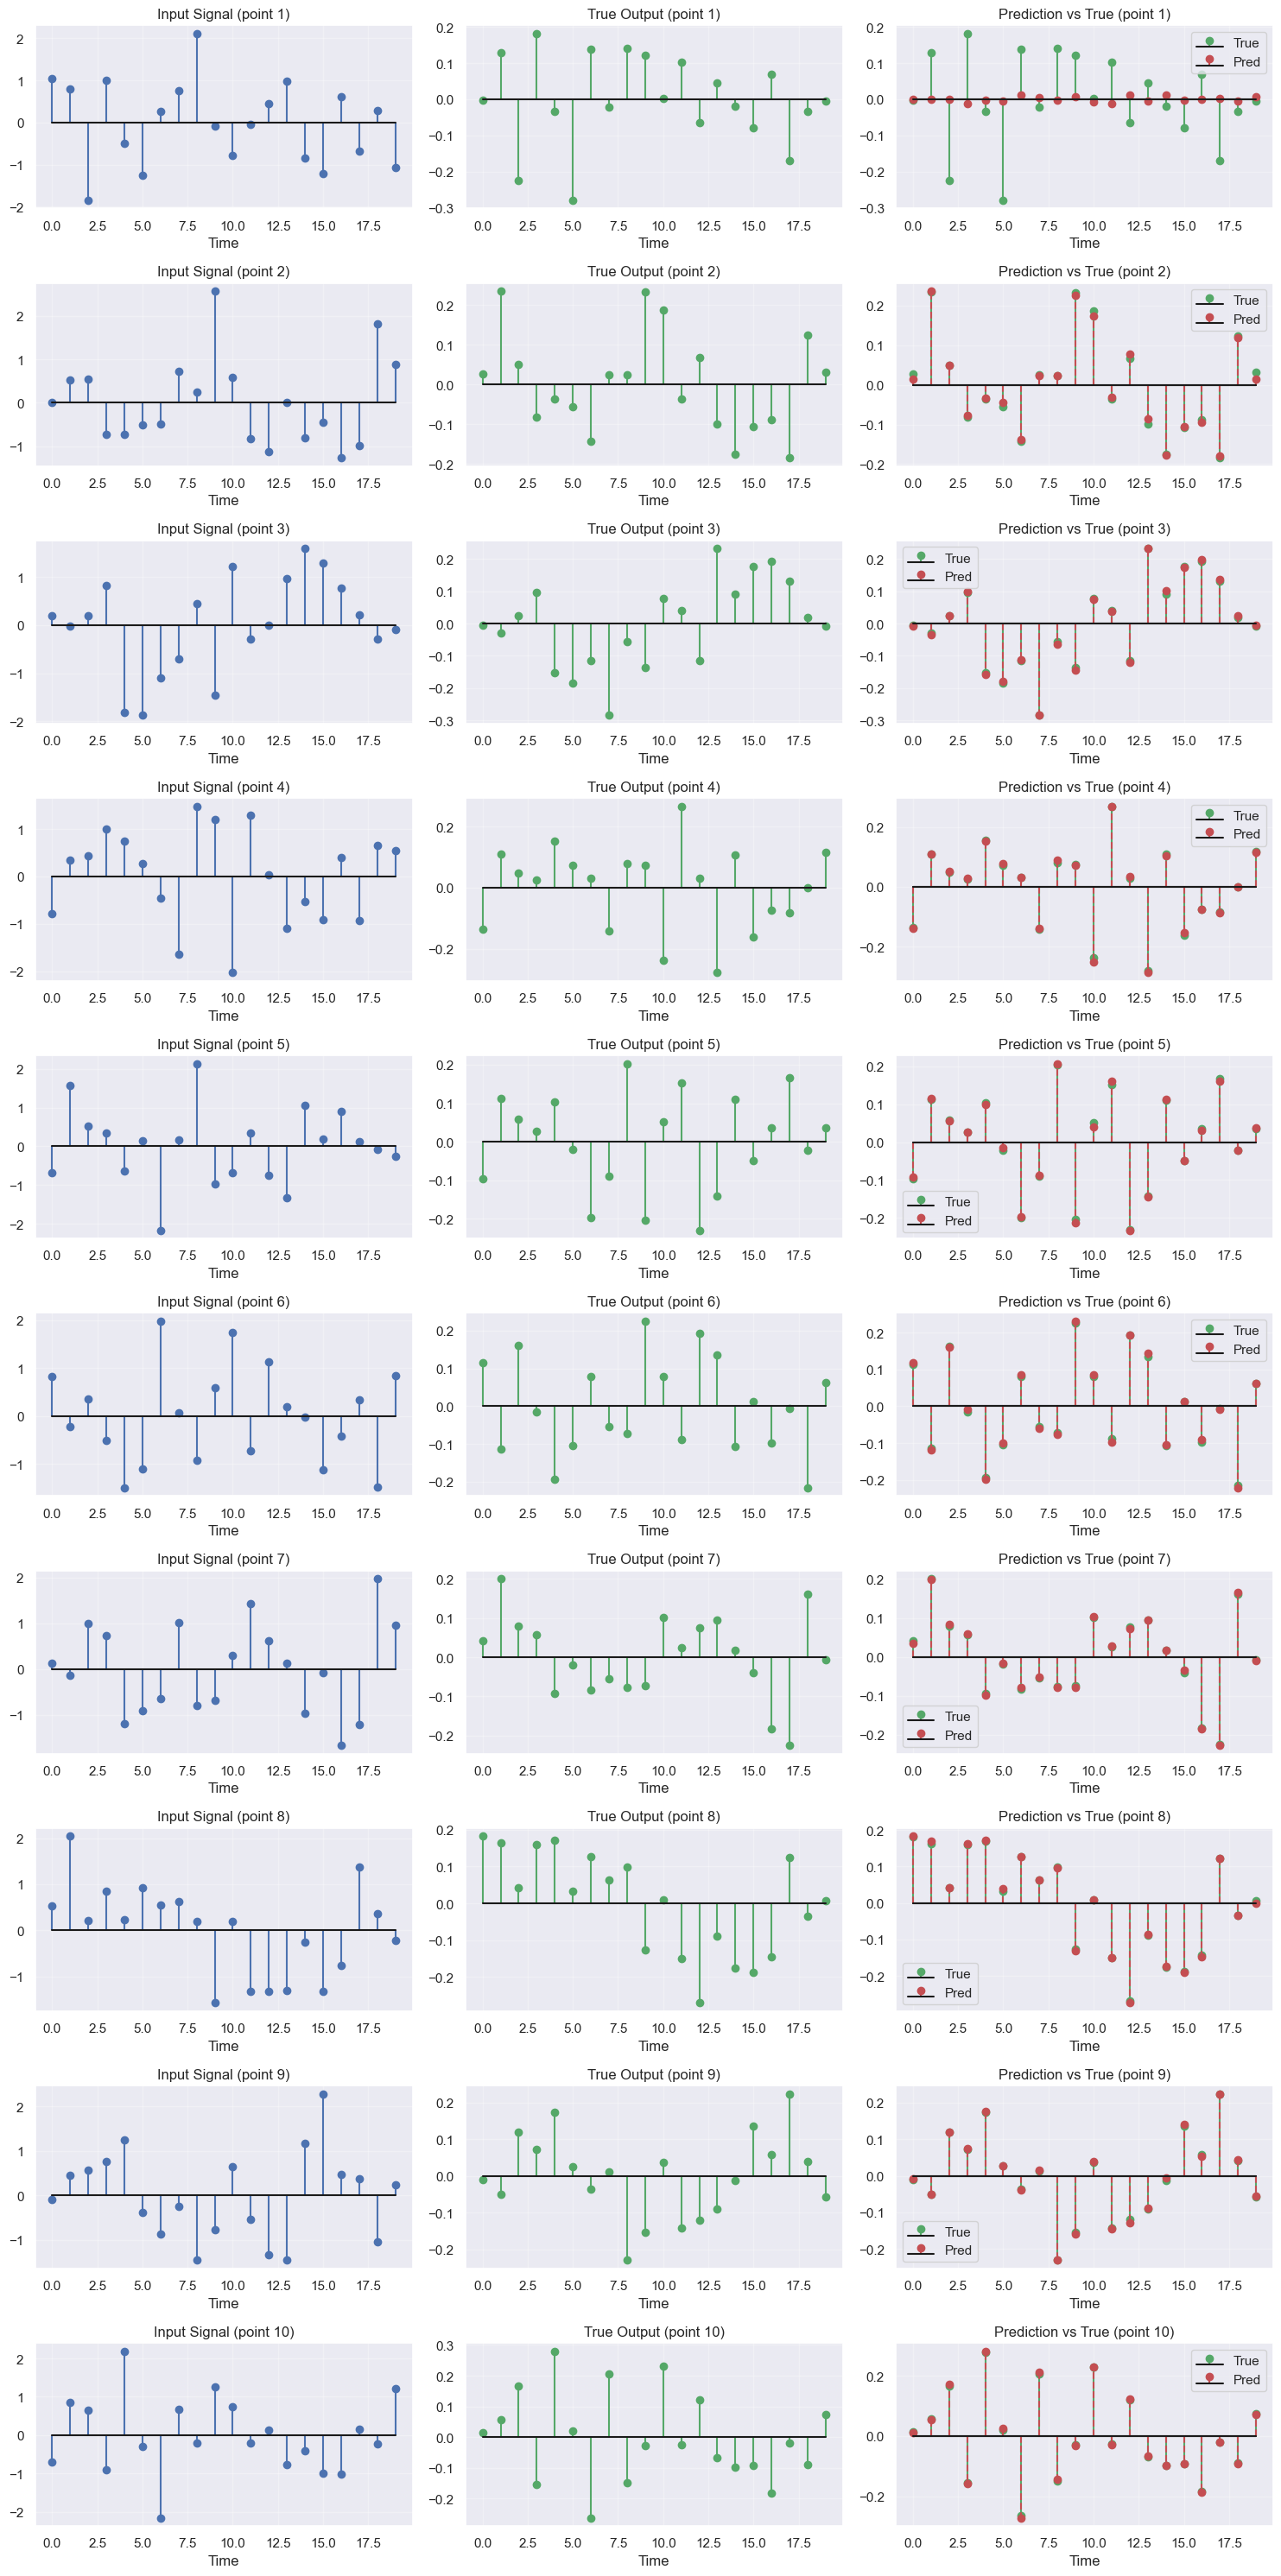

MSE for final point: 0.000012

Evaluating Time Period 20, FIR 20 from output/bigbatch_star ...
  Using FIR20 time domain data: torch.Size([256, 55, 20])


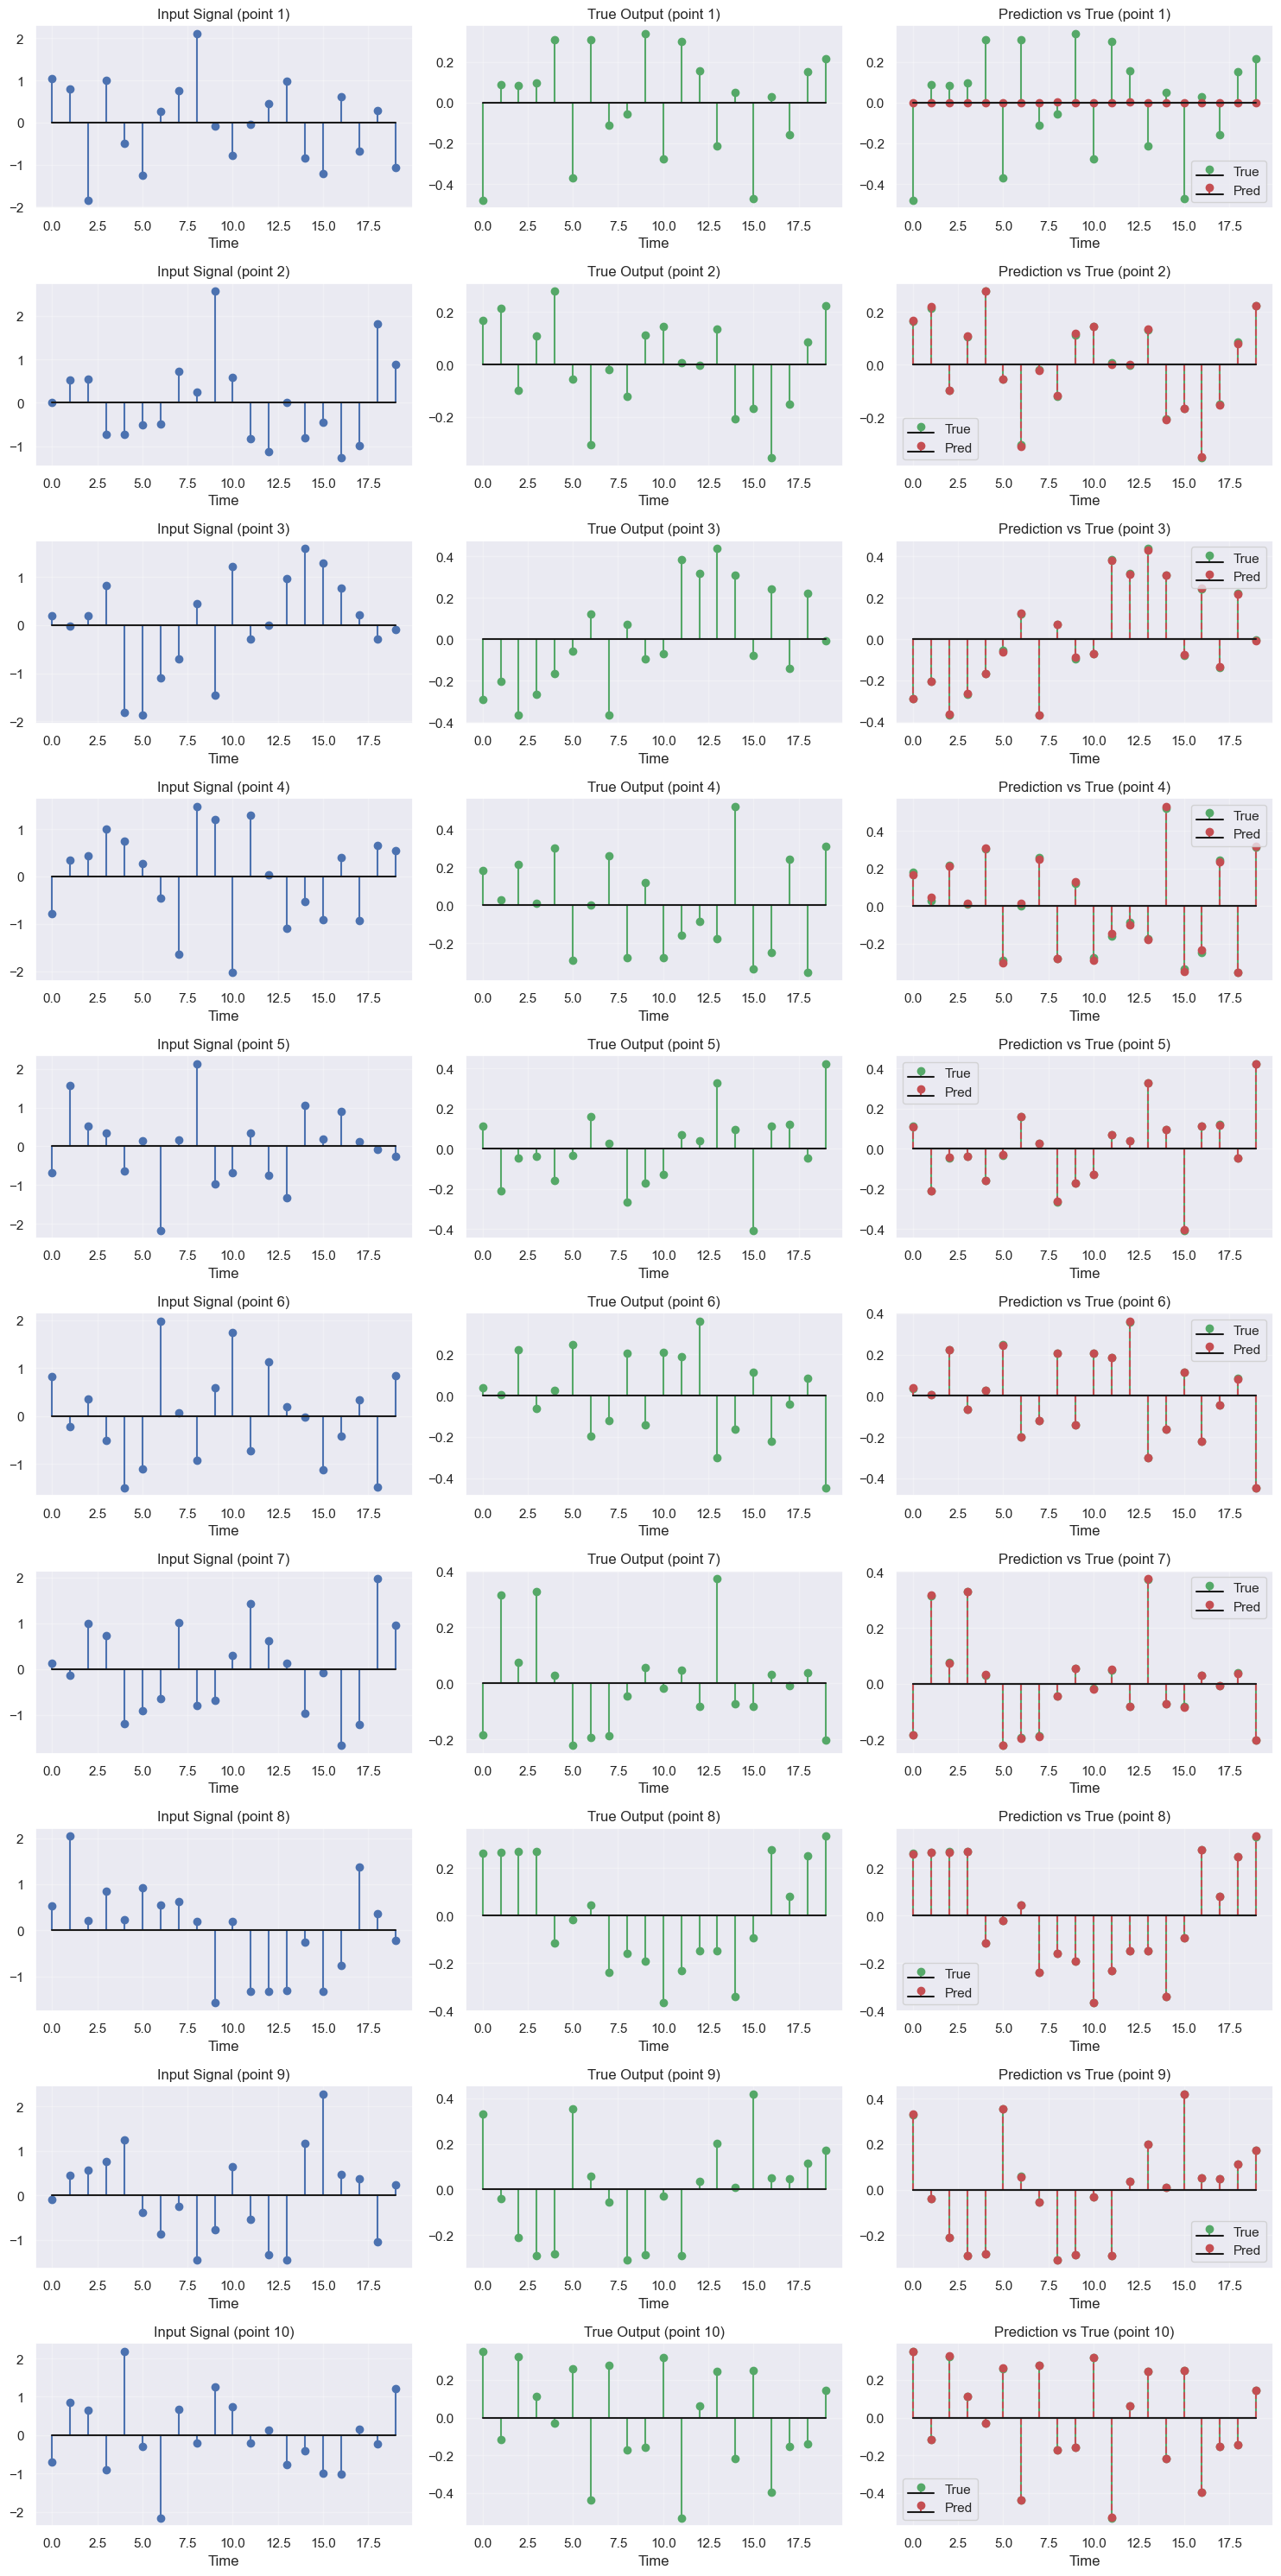

MSE for final point: 0.000001


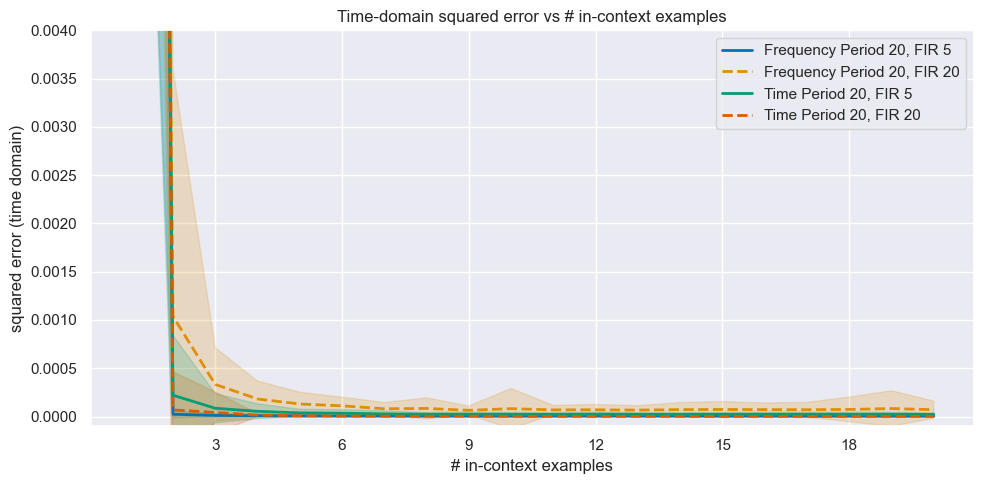

In [24]:
import numpy as np
from collections import OrderedDict

# Paths for the four models, grouped by FIR length
model_specs = OrderedDict([
    ("Frequency Period 20, FIR 5", ("output/freq_p20_fir5_loss_space_time_b256_dec8_1437", "fir5", -1)), #last argument for desired model checkpoint step. -1 uses state.pt
    ("Frequency Period 20, FIR 20", ("output/freq_p20_fir20_loss_space_time_b256_dec4_1443", "fir20", -1)),
    ("Time Period 20, FIR 5", ("output/time_p20_fir5_context_batch256_dec4_1229", "fir5", -1)),
    ("Time Period 20, FIR 20", ("output/bigbatch_star", "fir20", -1)), 
])

# Reference TIME-domain models for each FIR group (to get correct fir_len)
# We generate time-domain data and convert to freq for freq models
fir_group_refs = {
    "fir5": "output/time_p20_fir5_context_batch256_dec4_1229",  # fir_len=5
    "fir20": "output/bigbatch_star",  # fir_len=20
}

# Common evaluation settings
batch_size = 256
num_points = 55

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


# TEST DATA IS SHARED FOR ALL MODELS
shared_data = {}

for fir_group, ref_path in fir_group_refs.items():
    print(f"\n{'='*50}")
    print(f"Generating shared test data for {fir_group.upper()} group")
    print(f"{'='*50}")
    
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    ref_model, ref_conf = get_model_from_run(ref_path)
    ref_n_dims = ref_conf.model.n_dims

    print(f"  Reference model: {ref_path}")
    print(f"  fir_len: {ref_conf.training.task_kwargs.fir_len}")
    print(f"  num_freqs: {ref_conf.training.data_kwargs.num_freqs}")
    
    ref_data_kwargs = dict(ref_conf.training.data_kwargs)
    ref_task_kwargs = dict(ref_conf.training.task_kwargs)
    ref_data_kwargs["device"] = device
    ref_task_kwargs["device"] = device
    
    ref_data_sampler = get_data_sampler(ref_conf.training.data, ref_n_dims, **ref_data_kwargs)
    ref_task_sampler = get_task_sampler(
        ref_conf.training.task,
        ref_n_dims,
        batch_size,
        **ref_task_kwargs,
    )
    
    # Generate shared test signals and task (filter) in TIME domain
    shared_task = ref_task_sampler()
    xs_time = ref_data_sampler.sample_xs(b_size=batch_size, n_points=num_points)
    ys_time = shared_task.evaluate(xs_time)
    
    print(f"  xs_time shape: {xs_time.shape}")
    print(f"  ys_time shape: {ys_time.shape}")
    
    # Convert to frequency domain using the SAME method as the sampler
    # (rfft with norm="ortho", then interleave real/imag)
    xs_freq = time_to_interleaved_freq(xs_time)
    ys_freq = time_to_interleaved_freq(ys_time)
    
    print(f"  xs_freq shape: {xs_freq.shape}")
    print(f"  ys_freq shape: {ys_freq.shape}")
    
    shared_data[fir_group] = {
        "xs_time": xs_time,
        "ys_time": ys_time,
        "xs_freq": xs_freq,
        "ys_freq": ys_freq,
    }

#Evaluate each model
results_time_domain = OrderedDict()

for label, (run_path, fir_group, step) in model_specs.items():
    print(f"\nEvaluating {label} from {run_path} ...")
    
    model, conf = get_model_from_run(run_path, step=step)
    model = model.to(device)
    model.eval()

    domain = conf.training.data_kwargs.domain
    n_dims = conf.model.n_dims
    
    # Get shared data for this FIR group
    data = shared_data[fir_group]
    
    # Select input format based on model's domain
    if domain == "freq":
        xs_input = data["xs_freq"]
        ys_input = data["ys_freq"]
    else:
        xs_input = data["xs_time"]
        ys_input = data["ys_time"]
    
    print(f"  Using {fir_group.upper()} {domain} domain data: {xs_input.shape}")
    # Forward pass
    with torch.no_grad():
        xs_device = xs_input.to(device)
        ys_device = ys_input.to(device)
        pred = model(xs_device, ys_device).cpu()

    # Convert predictions to time domain for comparison
    if domain == "freq":
        p = (xs_input.shape[-1] - 1) * 2
        pred_time = interleaved_freq_to_time(pred, p)
    else:
        pred_time = pred

    # Compute per-point MSE in time domain (compare against time-domain ground truth)
    preds_np = pred_time.cpu().numpy()
    ys_np = data["ys_time"].cpu().numpy()
    
    per_point_mse = ((preds_np - ys_np) ** 2).mean(axis=2)

    mean_err = per_point_mse.mean(axis=0)
    std_err = per_point_mse.std(axis=0)

    results_time_domain[label] = {
        "mean": mean_err,
        "std": std_err,
        "fir_group": fir_group,
    }
    
    # Visualize examples
    if domain == "freq":
        xs_viz = interleaved_freq_to_time(xs_input, p)
    else:
        xs_viz = xs_input
    plot_signal_examples(xs_viz, data["ys_time"], pred_time, conf, example_idx=0, n_points_to_show=10)

#Plotting
plt.figure(figsize=(10, 5))

max_T = 20 #maximum number of in-context examples 
x_axis = np.arange(1, max_T + 1)

linestyles = {"fir5": "-", "fir20": "--"}

for idx, (label, stats) in enumerate(results_time_domain.items()):
    mean = stats["mean"][:max_T]
    std = stats["std"][:max_T]
    fir_group = stats["fir_group"]
    color = palette[idx % len(palette)] if "palette" in globals() else None

    plt.plot(x_axis, mean, label=label, linewidth=2, color=color, linestyle=linestyles[fir_group])
    plt.fill_between(x_axis, mean - std, mean + std, alpha=0.2, color=color)

plt.xlabel("# in-context examples")
plt.ylabel("squared error (time domain)")
plt.ylim(-.0001, 0.004)
plt.title("Time-domain squared error vs # in-context examples")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.legend()
plt.show()

## Dropping Lowest Frequency Components

In this section, we test the robustness of the models' prediction abilities by dropping the **lowest entries** of the input vector of frequnecy components, and comparing against the true output. Again, we compare four models by plotting their **time-domain squared error** as a function of the number of in-context examples. For each model we compute the per-point MSE across the batch and then plot the **batch mean** with a **standard deviation band**.

In [20]:
num_lowest = 10 #Vary this to change the number of components dropped


Generating shared test data for FIR5 group
  Reference model: output/time_p20_fir5_context_batch256_dec4_1229
  fir_len: 5
  Compressed (keeping top 10 frequencies):
    xs_time shape: torch.Size([256, 55, 20]), compressed: torch.Size([256, 55, 20])
    xs_freq shape: torch.Size([256, 55, 22]), compressed: torch.Size([256, 55, 22])

Generating shared test data for FIR20 group
  Reference model: output/bigbatch_star
  fir_len: 20
  Compressed (keeping top 10 frequencies):
    xs_time shape: torch.Size([256, 55, 20]), compressed: torch.Size([256, 55, 20])
    xs_freq shape: torch.Size([256, 55, 22]), compressed: torch.Size([256, 55, 22])

Evaluating Frequency Period 20, FIR 5 from output/freq_p20_fir5_loss_space_time_b256_dec8_1437 ...
  Using FIR5 freq domain compressed data: torch.Size([256, 55, 22])


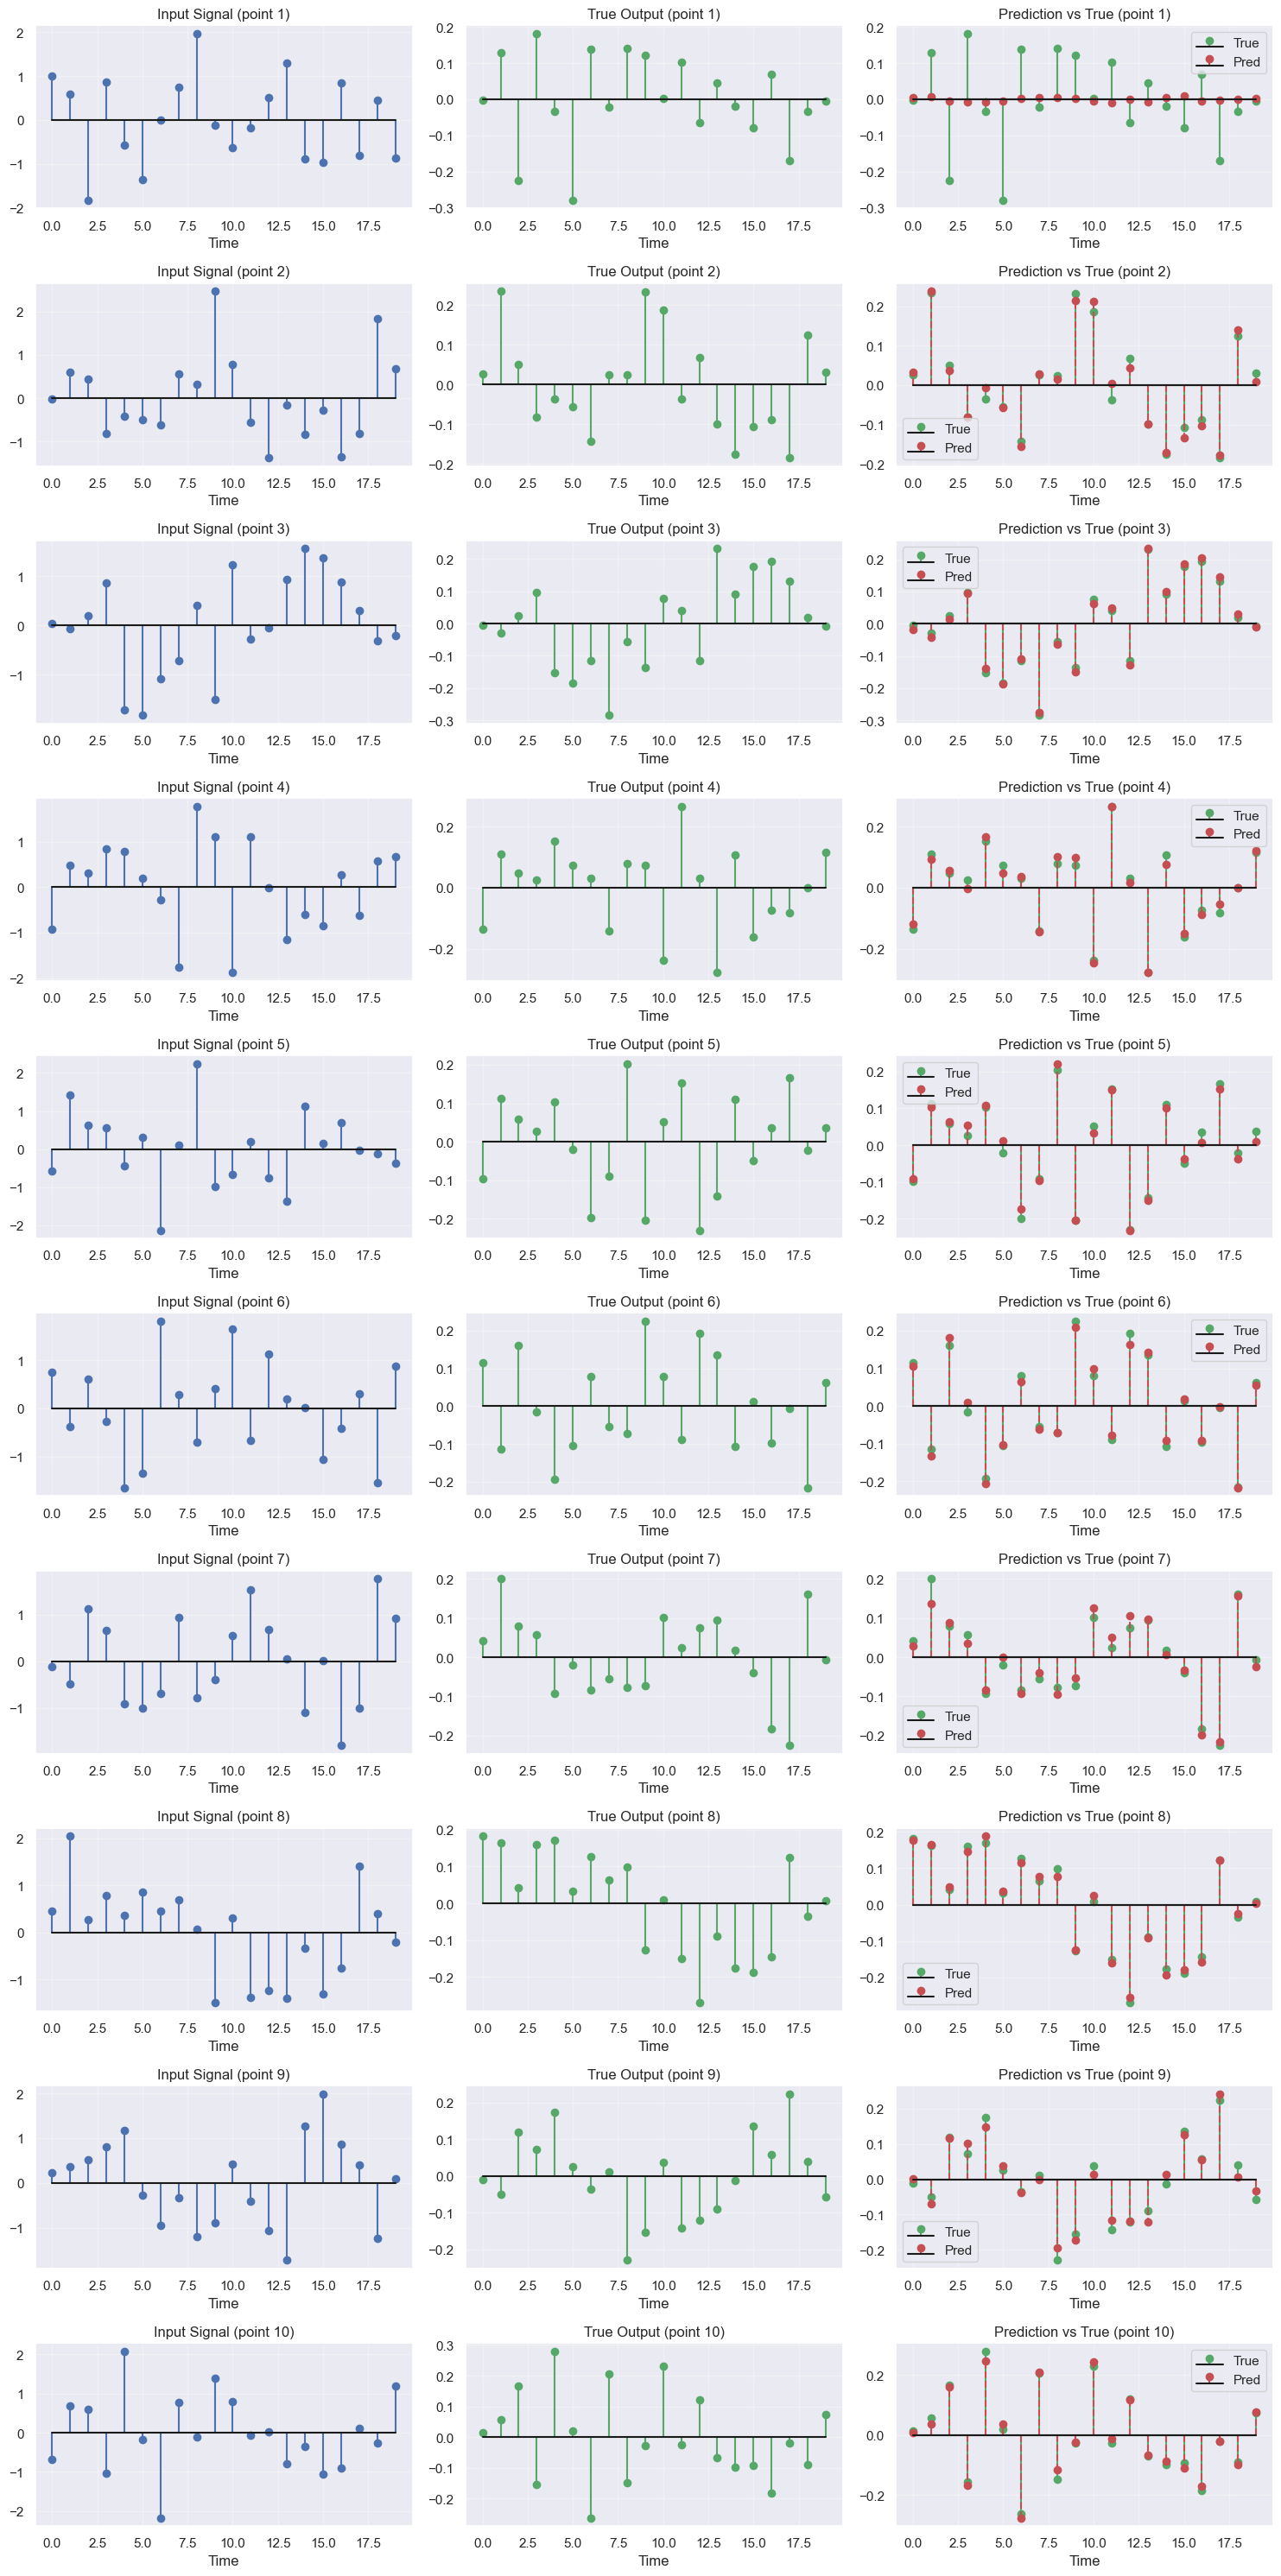

MSE for final point: 0.000223

Evaluating Frequency Period 20, FIR 20 from output/freq_p20_fir20_loss_space_time_b256_dec4_1443 ...
  Using FIR20 freq domain compressed data: torch.Size([256, 55, 22])


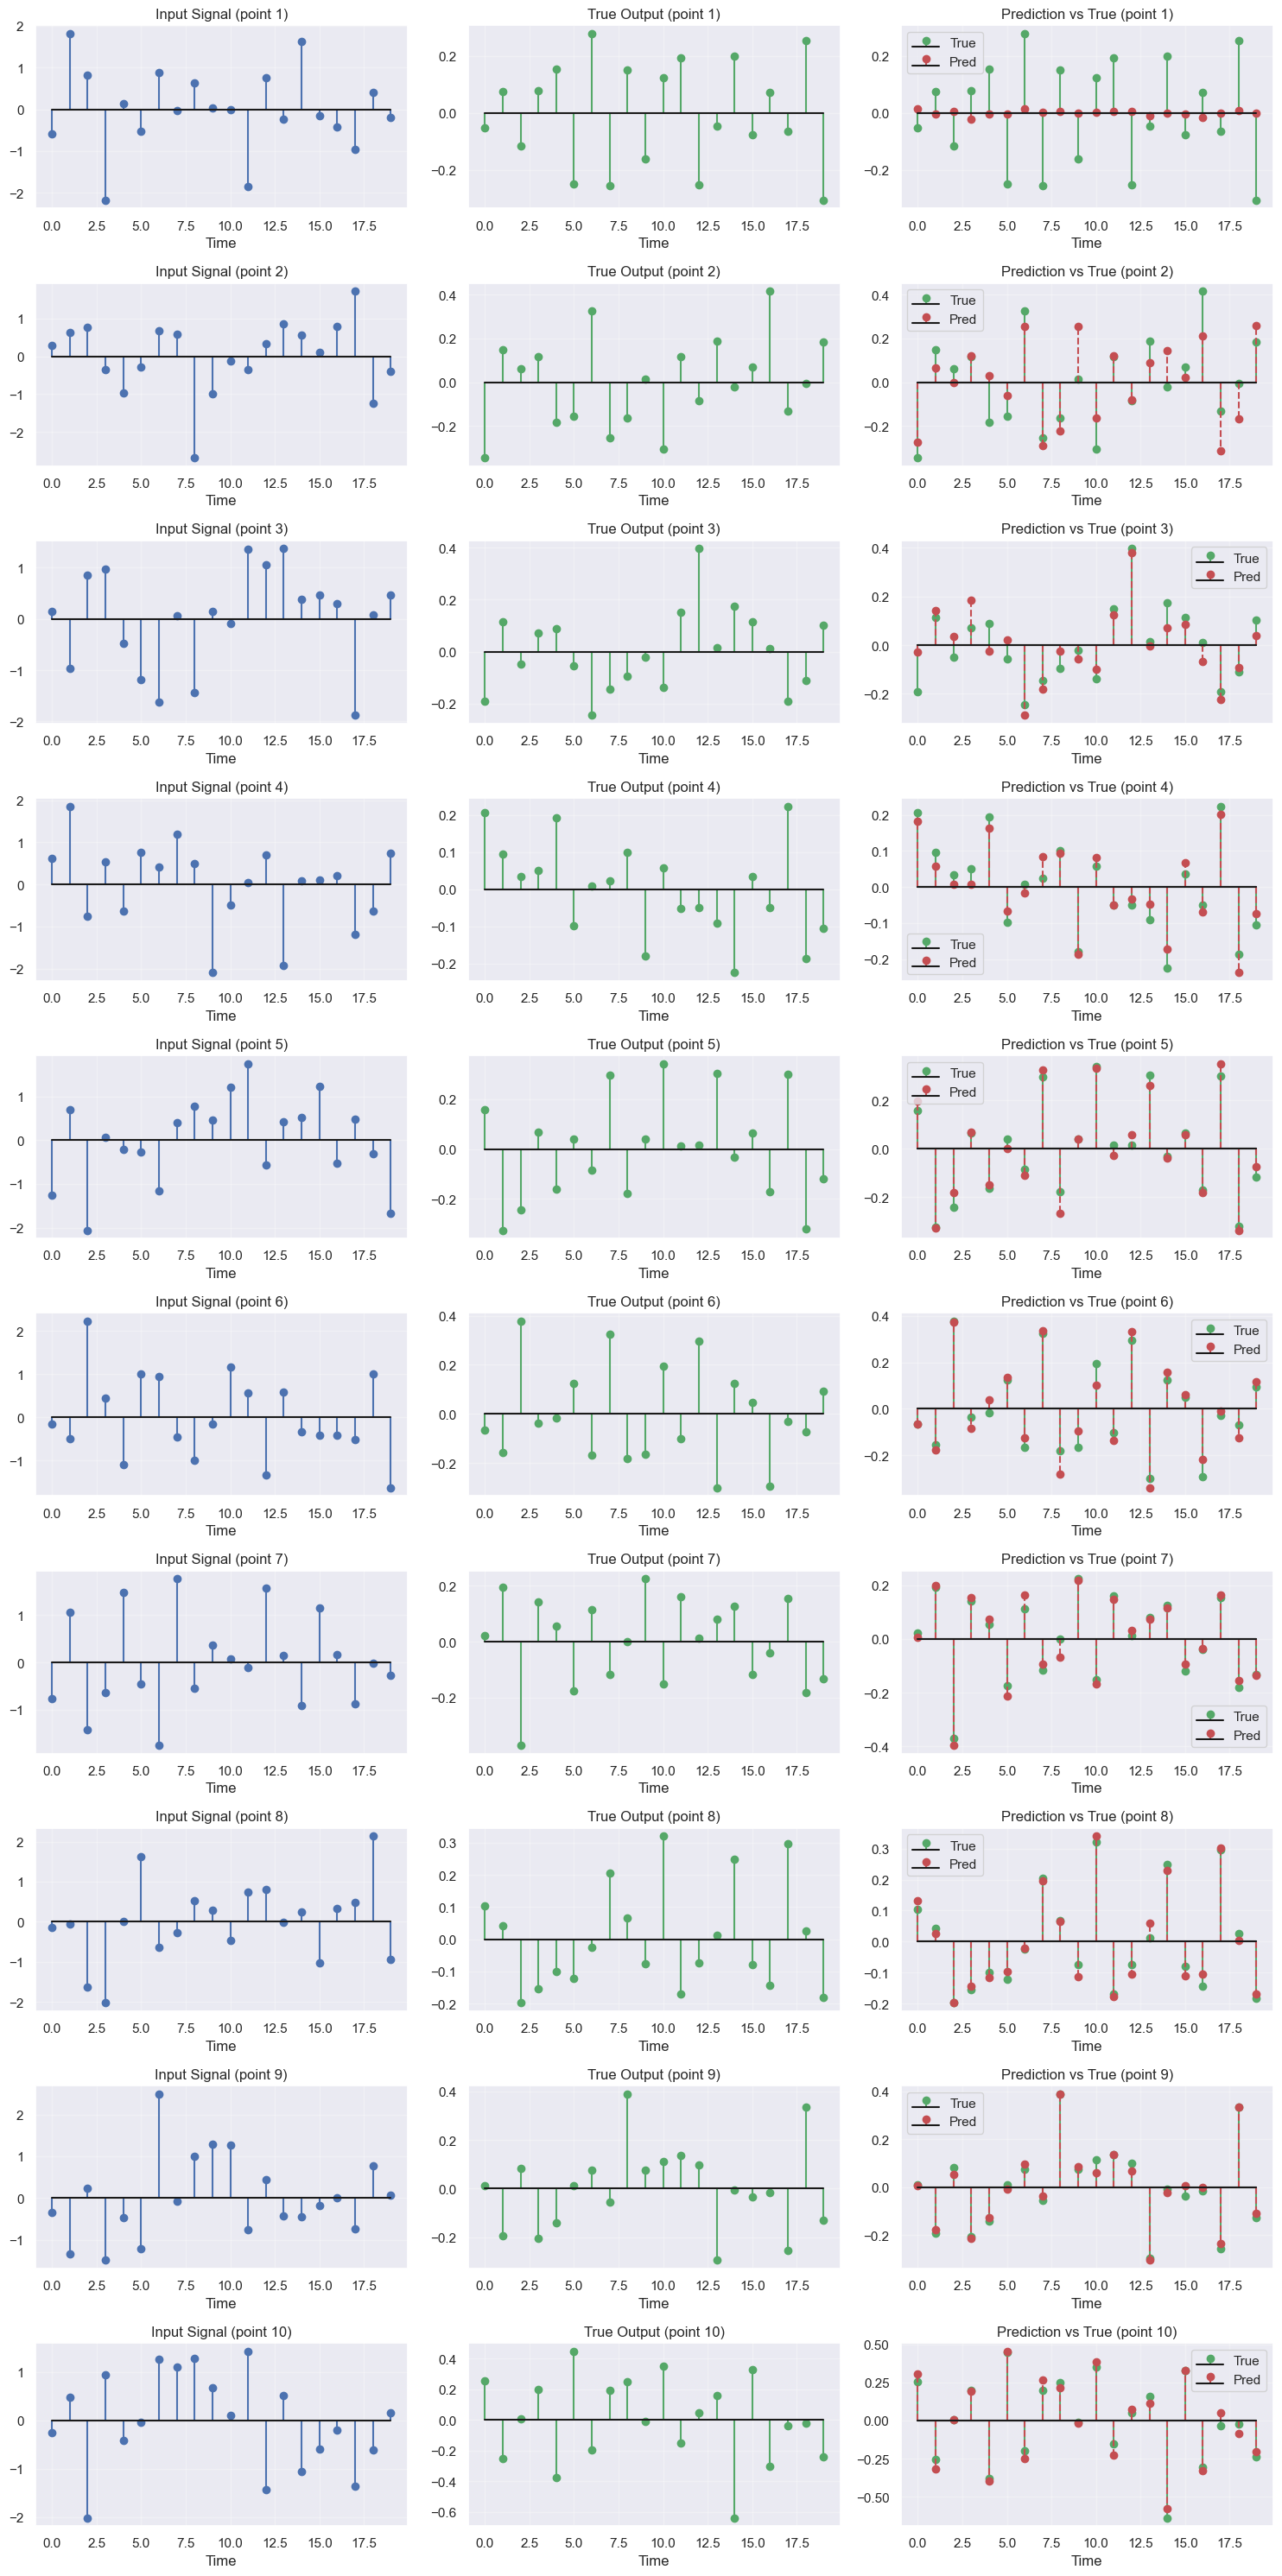

MSE for final point: 0.002096

Evaluating Time Period 20, FIR 5 from output/time_p20_fir5_context_batch256_dec4_1229 ...
  Using FIR5 time domain compressed data: torch.Size([256, 55, 20])


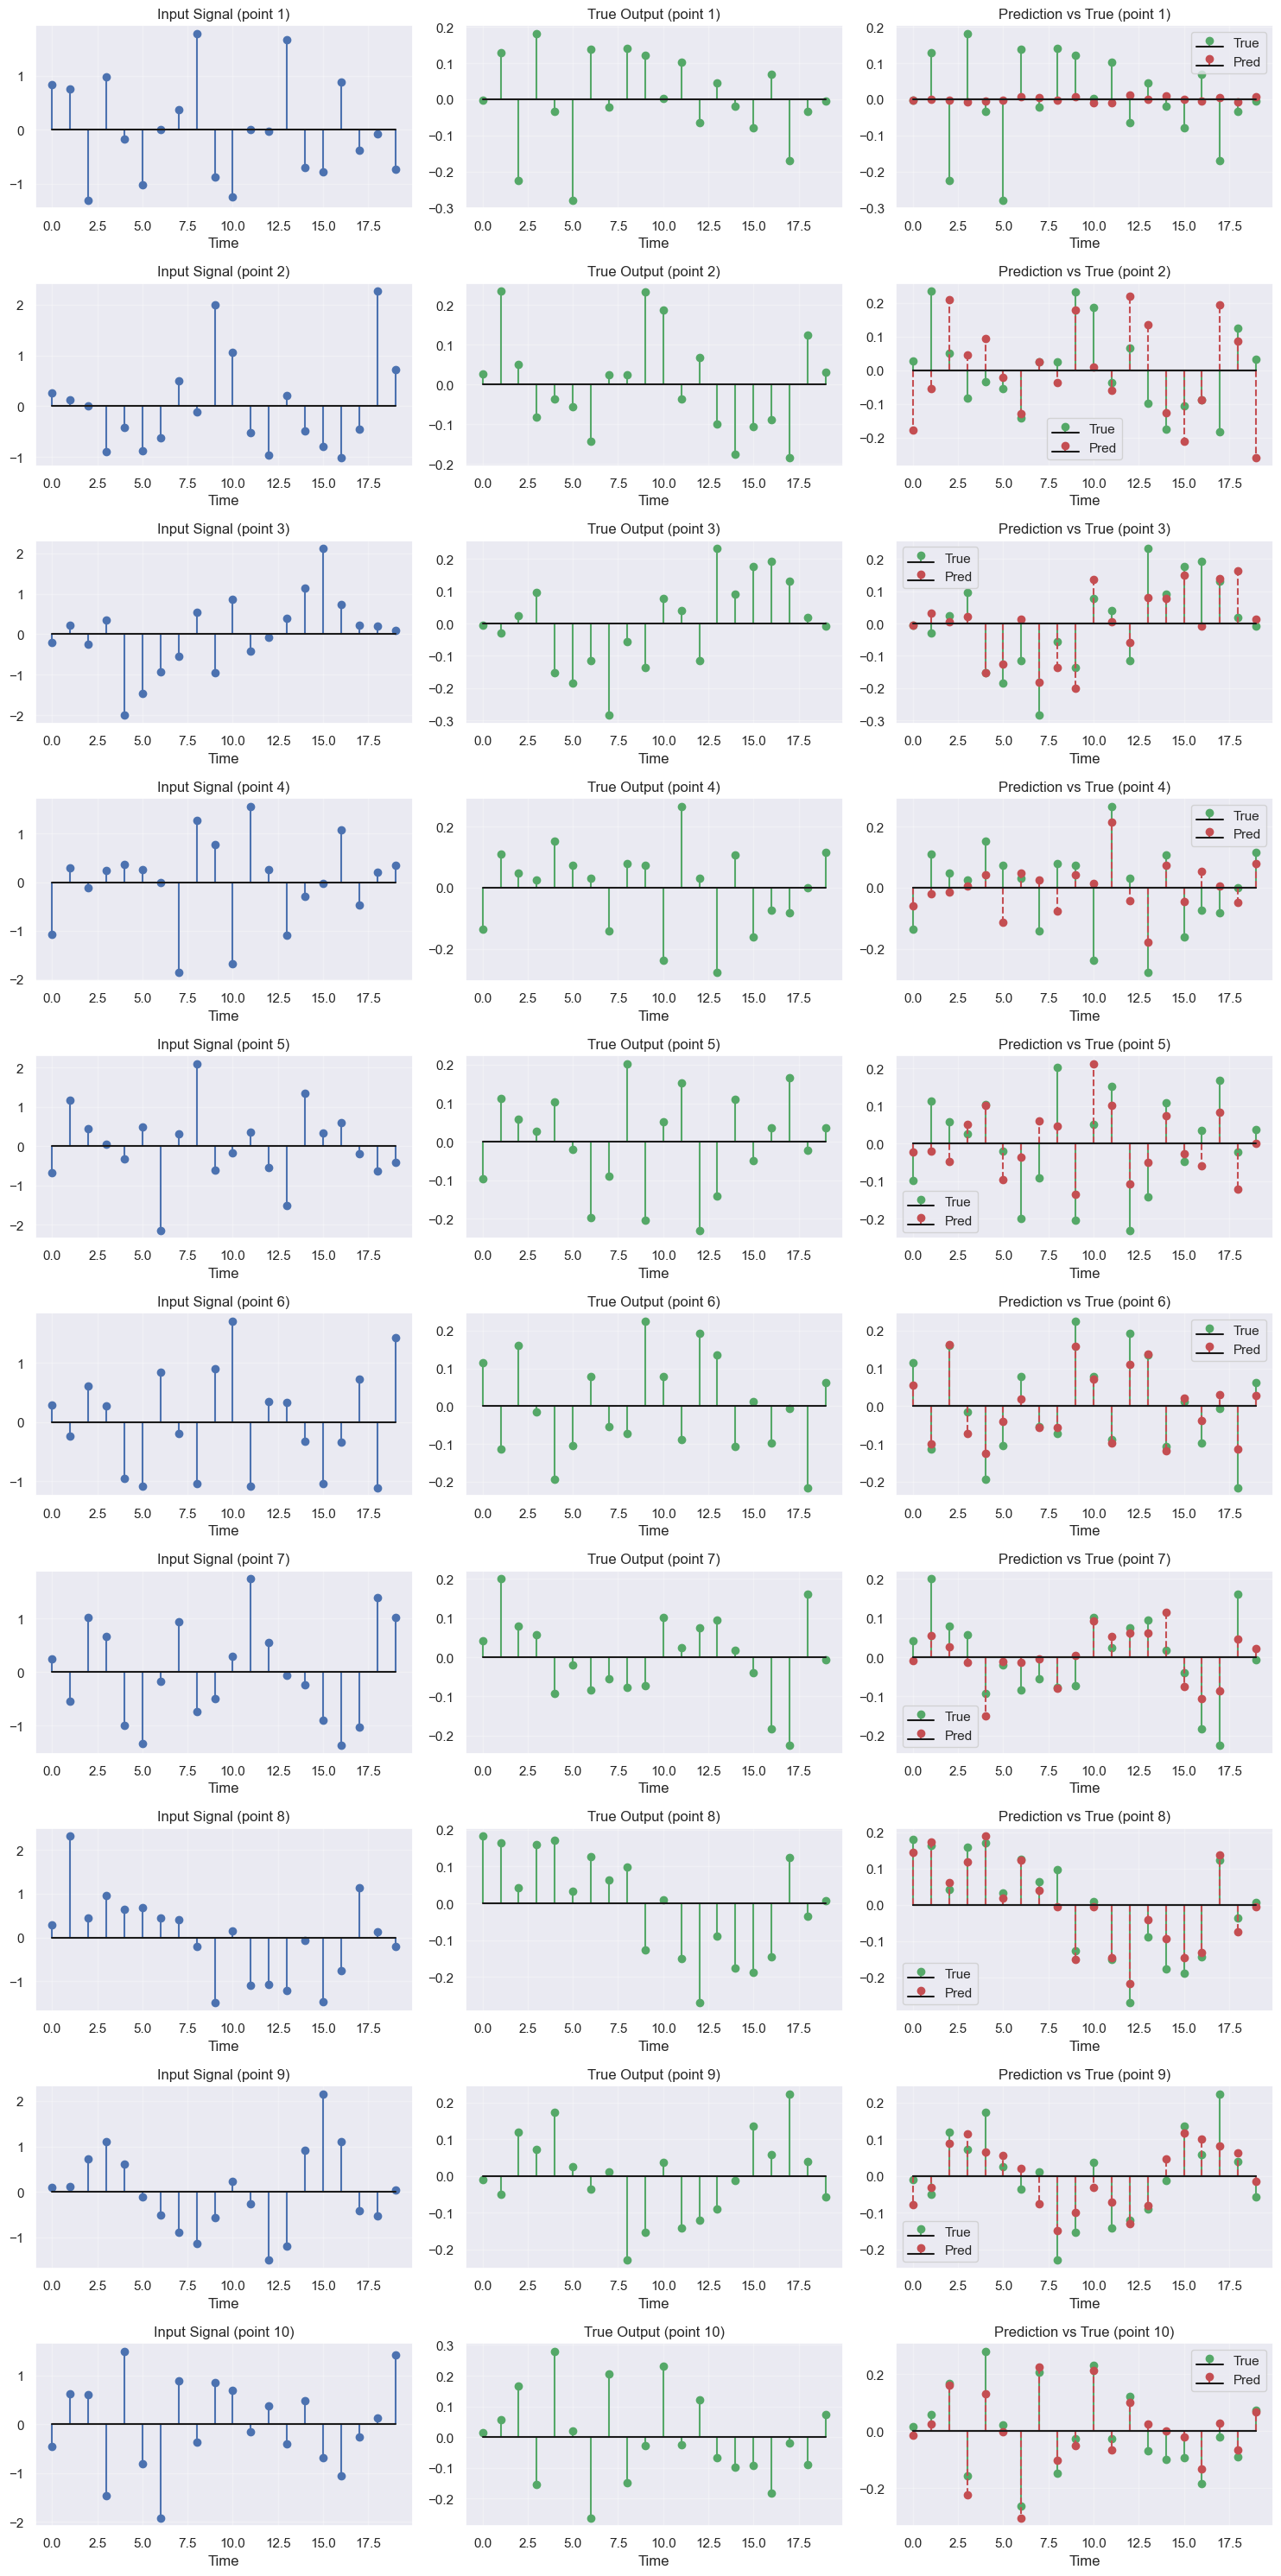

MSE for final point: 0.003247

Evaluating Time Period 20, FIR 20 from output/bigbatch_star ...
  Using FIR20 time domain compressed data: torch.Size([256, 55, 20])


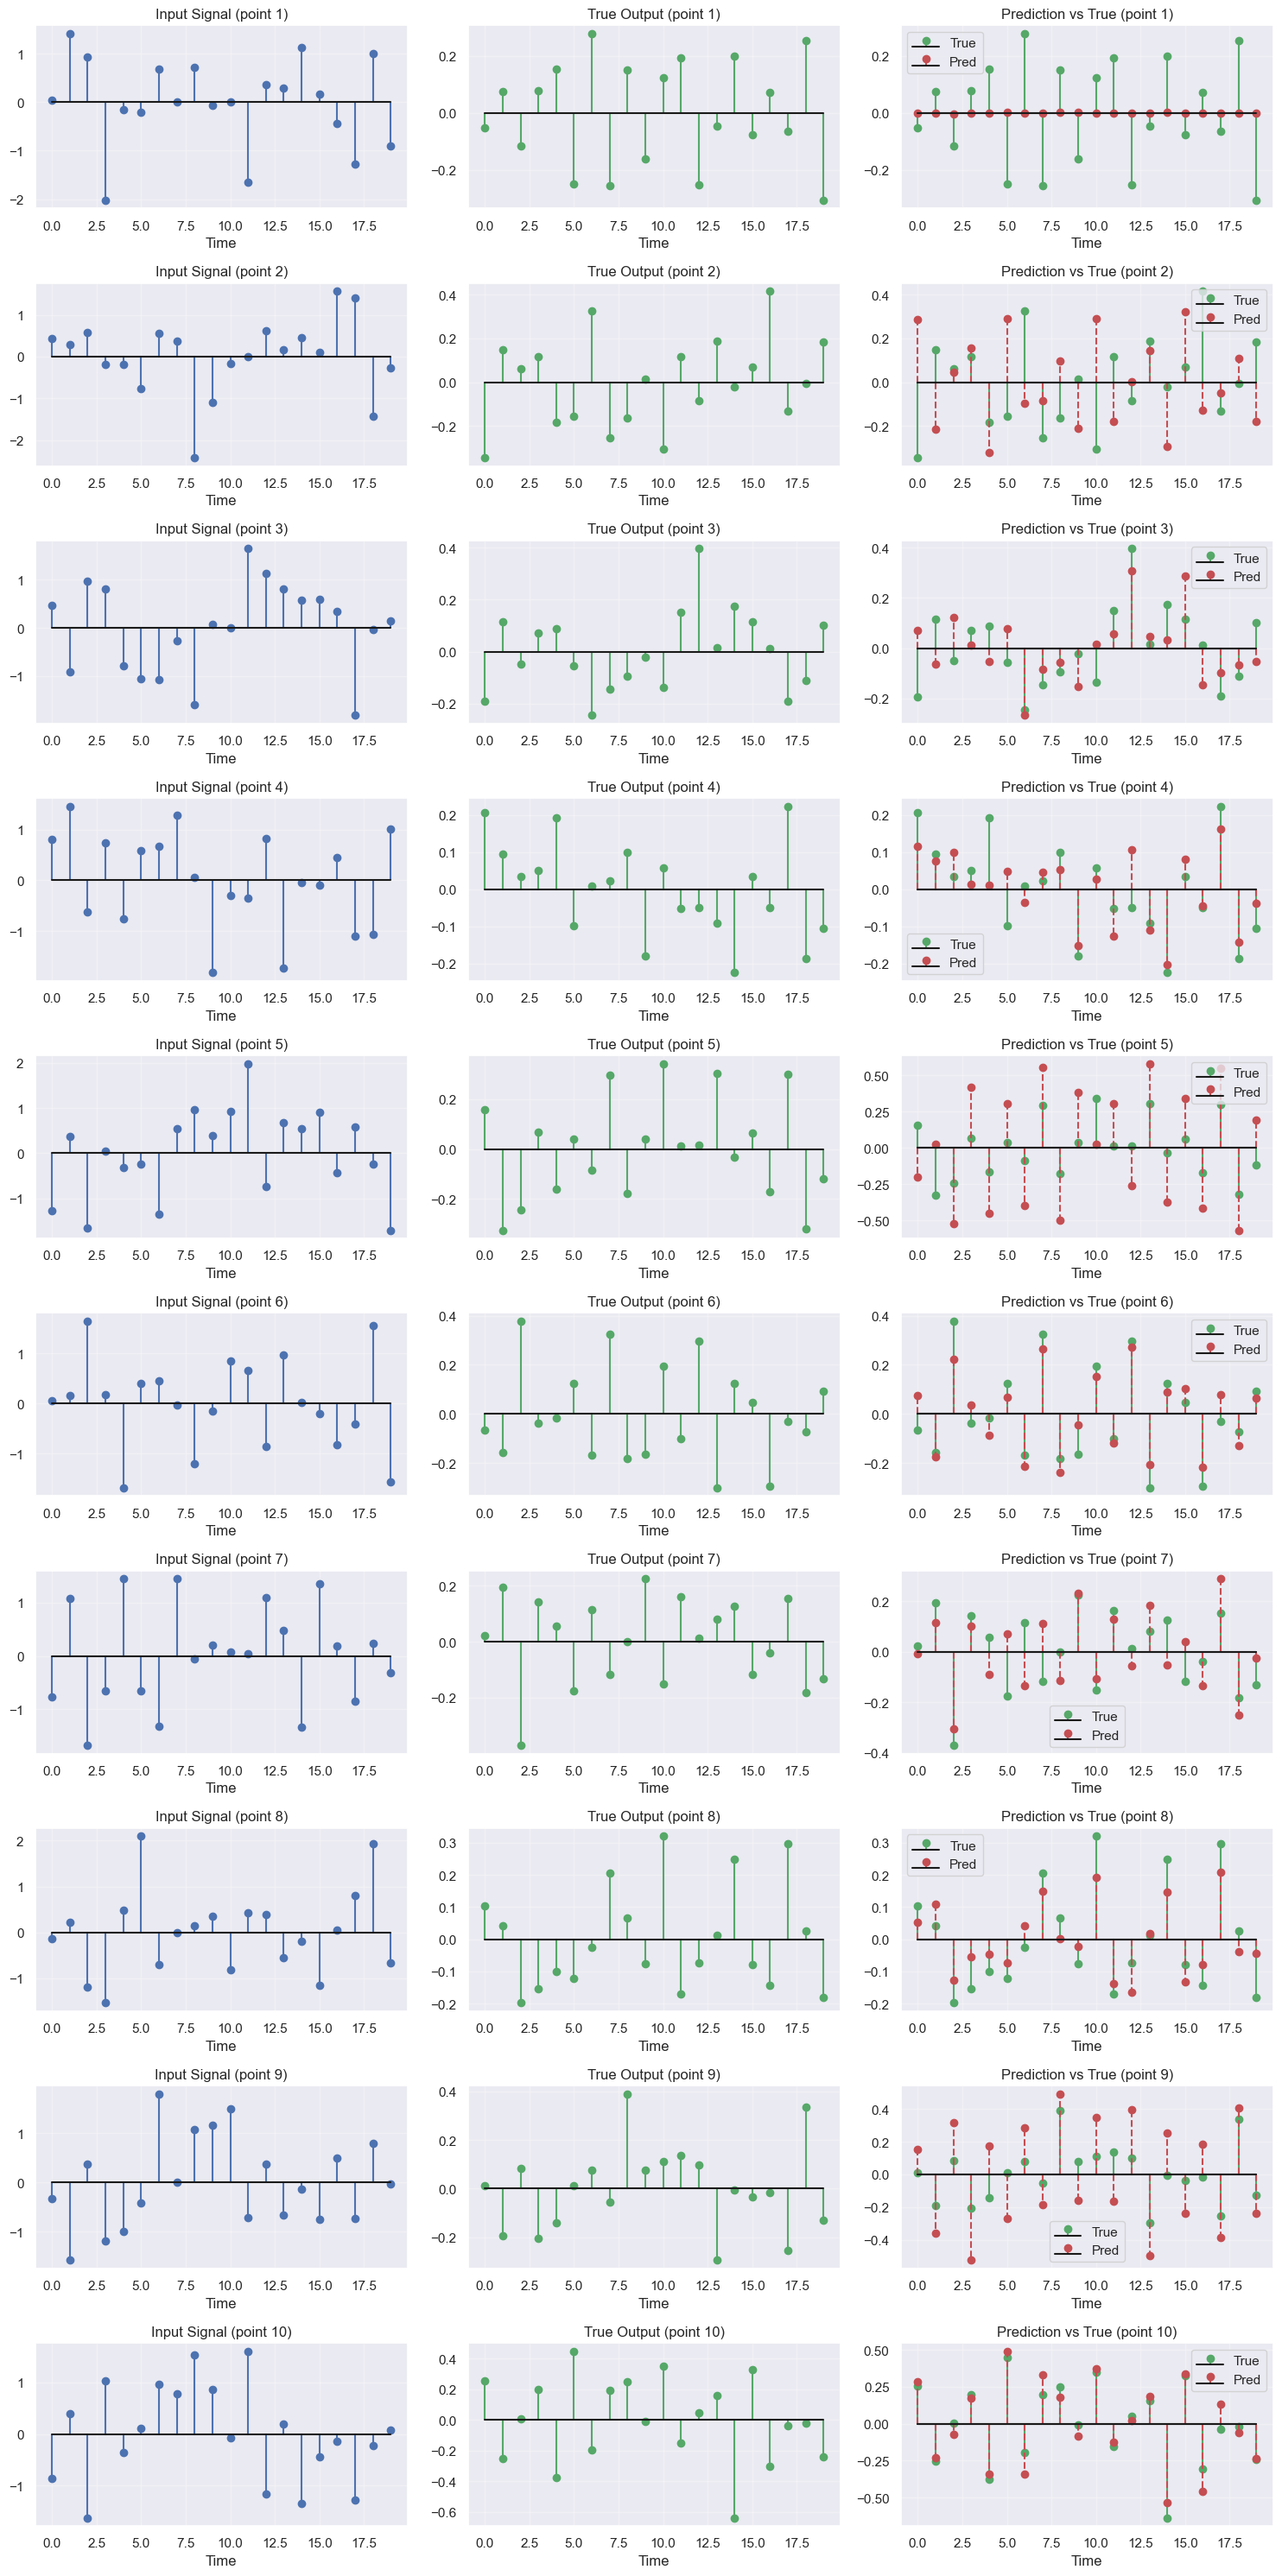

MSE for final point: 0.006390


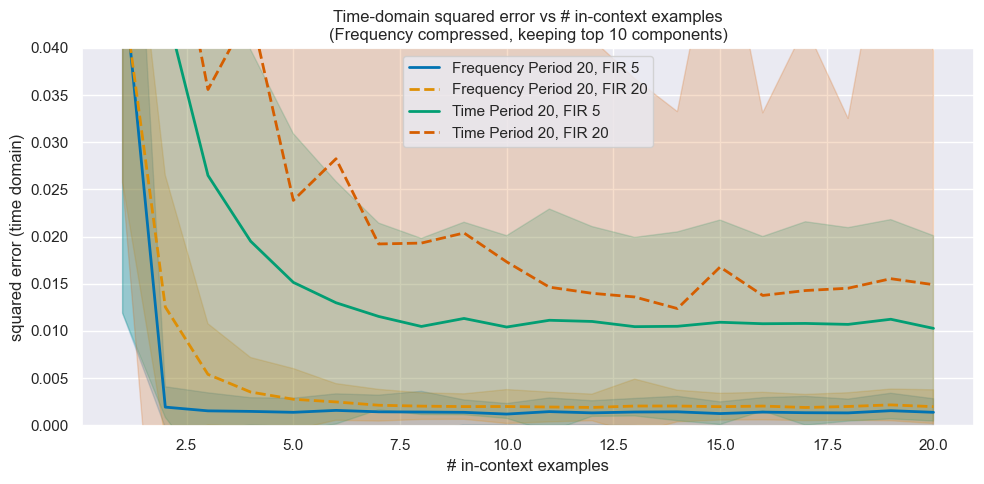

In [21]:
import numpy as np
from collections import OrderedDict

# Paths for the four models, grouped by FIR length
model_specs = OrderedDict([
    ("Frequency Period 20, FIR 5", ("output/freq_p20_fir5_loss_space_time_b256_dec8_1437", "fir5")),
    ("Frequency Period 20, FIR 20", ("output/freq_p20_fir20_loss_space_time_b256_dec4_1443", "fir20")),
    ("Time Period 20, FIR 5", ("output/time_p20_fir5_context_batch256_dec4_1229", "fir5")),
    ("Time Period 20, FIR 20", ("output/bigbatch_star", "fir20")), 
])

# Reference TIME-domain models for each FIR group (to get correct fir_len)
fir_group_refs = {
    "fir5": "output/time_p20_fir5_context_batch256_dec4_1229",  # fir_len=5
    "fir20": "output/bigbatch_star",  # fir_len=20
}

# Common evaluation settings
batch_size = 256
num_points = 55

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# ============================================================
# GENERATE SHARED TEST DATA FOR EACH FIR GROUP
# ============================================================
shared_data = {}

for fir_group, ref_path in fir_group_refs.items():
    print(f"\n{'='*50}")
    print(f"Generating shared test data for {fir_group.upper()} group")
    print(f"{'='*50}")
    
    seed = 42 if fir_group == "fir5" else 43
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    ref_model, ref_conf = get_model_from_run(ref_path)
    ref_n_dims = ref_conf.model.n_dims
    
    print(f"  Reference model: {ref_path}")
    print(f"  fir_len: {ref_conf.training.task_kwargs.fir_len}")
    
    ref_data_kwargs = dict(ref_conf.training.data_kwargs)
    ref_task_kwargs = dict(ref_conf.training.task_kwargs)
    ref_data_kwargs["device"] = device
    ref_task_kwargs["device"] = device
    
    ref_data_sampler = get_data_sampler(ref_conf.training.data, ref_n_dims, **ref_data_kwargs)
    ref_task_sampler = get_task_sampler(
        ref_conf.training.task,
        ref_n_dims,
        batch_size,
        **ref_task_kwargs,
    )
    
    # Generate shared test signals and task (filter) in TIME domain
    shared_task = ref_task_sampler()
    xs_time = ref_data_sampler.sample_xs(b_size=batch_size, n_points=num_points)
    ys_time = shared_task.evaluate(xs_time)
    
    # Convert to frequency domain
    xs_freq = time_to_interleaved_freq(xs_time)
    ys_freq = time_to_interleaved_freq(ys_time)
        
    # Frequency Compression
    X_freq_thresh = torch.kthvalue(torch.abs(xs_freq), k=num_lowest, dim=2).values.unsqueeze(2)
    mask_freq = torch.abs(xs_freq) > X_freq_thresh
    xs_freq_compressed = xs_freq * mask_freq
    
    # Time Compression
    xs_time_fft = torch.fft.fft(xs_time, dim=-1, norm="ortho") 
    X_time_mag = torch.abs(xs_time_fft)
    X_time_thresh = torch.kthvalue(torch.abs(xs_time_fft), k=num_lowest, dim=2).values.unsqueeze(2)
    mask_time = X_time_mag > X_time_thresh
    xs_time_fft_masked = xs_time_fft * mask_time
    xs_time_compressed = torch.fft.ifft(xs_time_fft_masked, n=xs_time.shape[-1], dim=-1, norm="ortho").real #convert back to time domain
    
    print(f"  Compressed (keeping top {num_lowest} frequencies):")
    print(f"    xs_time shape: {xs_time.shape}, compressed: {xs_time_compressed.shape}")
    print(f"    xs_freq shape: {xs_freq.shape}, compressed: {xs_freq_compressed.shape}")
    
    shared_data[fir_group] = {
        "xs_time": xs_time,
        "ys_time": ys_time,
        "xs_freq": xs_freq,
        "ys_freq": ys_freq,
        "xs_time_compressed": xs_time_compressed,
        "xs_freq_compressed": xs_freq_compressed,
    }

#Evaluation
results_time_domain = OrderedDict()

for label, (run_path, fir_group) in model_specs.items():
    print(f"\nEvaluating {label} from {run_path} ...")

    model, conf = get_model_from_run(run_path)
    model = model.to(device)
    model.eval()

    domain = conf.training.data_kwargs.domain
    n_dims = conf.model.n_dims
    
    # Get shared data for this FIR group
    data = shared_data[fir_group]
    
    # Select COMPRESSED input format based on model's domain
    if domain == "freq":
        xs_input = data["xs_freq_compressed"]
        ys_input = data["ys_freq"]  # Uncompressed ground truth
    else:
        xs_input = data["xs_time_compressed"]
        ys_input = data["ys_time"]  # Uncompressed ground truth
    
    print(f"  Using {fir_group.upper()} {domain} domain compressed data: {xs_input.shape}")

    # Forward pass
    with torch.no_grad():
        xs_device = xs_input.to(device)
        ys_device = ys_input.to(device)
        pred = model(xs_device, ys_device).cpu()

    # Convert predictions to time domain for comparison
    if domain == "freq":
        p = (xs_input.shape[-1] - 1) * 2
        pred_time = interleaved_freq_to_time(pred, p)
    else:
        pred_time = pred

    # Compute per-point MSE in time domain
    preds_np = pred_time.cpu().numpy()
    ys_np = data["ys_time"].cpu().numpy()
    
    per_point_mse = ((preds_np - ys_np) ** 2).mean(axis=2)

    mean_err = per_point_mse.mean(axis=0)
    std_err = per_point_mse.std(axis=0)

    results_time_domain[label] = {
        "mean": mean_err,
        "std": std_err,
        "fir_group": fir_group,
    }
    
    # Visualize examples
    if domain == "freq":
        xs_viz = interleaved_freq_to_time(xs_input, p)
    else:
        xs_viz = xs_input
    plot_signal_examples(xs_viz, data["ys_time"], pred_time, conf, example_idx=0, n_points_to_show=10)

# ============================================================
# PLOT COMPARISON
# ============================================================
plt.figure(figsize=(10, 5))

max_T = 20
x_axis = np.arange(1, max_T + 1)

linestyles = {"fir5": "-", "fir20": "--"}

for idx, (label, stats) in enumerate(results_time_domain.items()):
    mean = stats["mean"][:max_T]
    std = stats["std"][:max_T]
    fir_group = stats["fir_group"]
    color = palette[idx % len(palette)] if "palette" in globals() else None

    plt.plot(x_axis, mean, label=label, linewidth=2, color=color, linestyle=linestyles[fir_group])
    plt.fill_between(x_axis, mean - std, mean + std, alpha=0.2, color=color)

plt.xlabel("# in-context examples")
plt.ylabel("squared error (time domain)")
plt.ylim(-.0001, 0.04)
plt.title(f"Time-domain squared error vs # in-context examples\n(Frequency compressed, keeping top {num_lowest} components)")
plt.tight_layout()
plt.legend()
plt.show()